In [1]:
!pip install av

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39.7/39.7 MB 40.4 MB/s eta 0:00:00


# Cell 1: ÂØºÂÖ•Â∫ìÂíåÁéØÂ¢ÉËÆæÁΩÆ

In [2]:
# Cell 1: ÂØºÂÖ•Â∫ìÂíåÁéØÂ¢ÉËÆæÁΩÆ

# ‰øÆÂ§çCUDAÂ§öËøõÁ®ãÈóÆÈ¢ò
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # Â¶ÇÊûúÂ∑≤ÁªèËÆæÁΩÆËøáÔºåÂøΩÁï•ÈîôËØØ

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
import gc
import json
import time
import sys
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# PyTorchÁõ∏ÂÖ≥
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.io import read_video
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# Êú∫Âô®Â≠¶‰π†ÊåáÊ†á
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split

# Á≥ªÁªüÁõëÊéßÂíåÊÄßËÉΩÂàÜÊûê
import psutil
import traceback


# ËßÜÈ¢ëÂ§ÑÁêÜ (PyAV)
try:
    import av
    PYAV_AVAILABLE = True
    print("‚úÖ PyAVÂ∑≤ÂÆâË£ÖÔºåÊîØÊåÅGPUËßÜÈ¢ëÂ§ÑÁêÜ")
except ImportError:
    PYAV_AVAILABLE = False
    print("‚ö†Ô∏è PyAVÊú™ÂÆâË£ÖÔºåËßÜÈ¢ëÂ§ÑÁêÜÂ∞ÜÂõûÈÄÄÂà∞CPUÊ®°Âºè")

# Êï∞ÊçÆÂ¢ûÂº∫
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    print("Ë≠¶Âëä: albumentationsÊú™ÂÆâË£ÖÔºåÂ∞Ü‰ΩøÁî®Âü∫Á°ÄÊï∞ÊçÆÂ¢ûÂº∫")

print("‚úÖ ÊâÄÊúâÂ∫ìÂØºÂÖ•ÂÆåÊàê")

‚úÖ PyAVÂ∑≤ÂÆâË£ÖÔºåÊîØÊåÅGPUËßÜÈ¢ëÂ§ÑÁêÜ
‚úÖ ÊâÄÊúâÂ∫ìÂØºÂÖ•ÂÆåÊàê


# Cell 2: ÂÖ®Â±ÄÈÖçÁΩÆÂíåÂ∑•ÂÖ∑ÂáΩÊï∞

In [3]:
# Cell 2: ÂÖ®Â±ÄÈÖçÁΩÆÂíåÂ∑•ÂÖ∑ÂáΩÊï∞ - Kaggle T4 ‰ºòÂåñÁâàÊú¨

def set_seed(seed=42):
    """ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠êÁ°Æ‰øùÂèØÈáçÂ§çÊÄß"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # KaggleÁéØÂ¢É‰ºòÂåñÔºöÂπ≥Ë°°ÊÄßËÉΩÂíåÂèØÈáçÂ§çÊÄß
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Kaggle T4 GPUÈÖçÁΩÆ
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPUÂûãÂè∑: {gpu_name}")
    print(f"GPUÂÜÖÂ≠ò: {gpu_memory:.1f} GB")
    
    # Kaggle T4 GPU‰ºòÂåñÈÖçÁΩÆ
    torch.cuda.set_per_process_memory_fraction(0.9)  # ‰øùÂÆàÂÜÖÂ≠ò‰ΩøÁî®
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("‚úÖ Kaggle T4 GPU‰ºòÂåñÈÖçÁΩÆÂ∑≤ÂêØÁî®")

# ÂàõÂª∫ÂøÖË¶ÅÁöÑÁõÆÂΩï
for dir_name in ['./data', './models', './logs', './results']:
    os.makedirs(dir_name, exist_ok=True)

# KaggleÁéØÂ¢ÉÊ£ÄÊµã
IS_KAGGLE = os.path.exists('/kaggle')
BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23' if IS_KAGGLE else './FaceForensics++_C23'

# Áªü‰∏ÄÊï∞ÊçÆÁ±ªÂûãÈÖçÁΩÆ - ÂÖ®ÈÉ®‰ΩøÁî®FP32ÊèêÂçáÂÖºÂÆπÊÄß
USE_FP32_ONLY = True  # Âº∫Âà∂‰ΩøÁî®FP32ÔºåÁ°Æ‰øùÊúÄ‰Ω≥ÂÖºÂÆπÊÄß
print(f"Êï∞ÊçÆÁ±ªÂûãÁ≠ñÁï•: FP32 (ÂÖºÂÆπÊÄß‰ºòÂÖà)")

print(f"ÁéØÂ¢É: {'Kaggle' if IS_KAGGLE else 'Êú¨Âú∞'}")
print(f"Êï∞ÊçÆÂü∫Á°ÄË∑ØÂæÑ: {BASE_DATA_DIR}")
print("‚úÖ ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàê")

‰ΩøÁî®ËÆæÂ§á: cuda
GPUÂûãÂè∑: Tesla T4
GPUÂÜÖÂ≠ò: 14.7 GB
‚úÖ Kaggle T4 GPU‰ºòÂåñÈÖçÁΩÆÂ∑≤ÂêØÁî®
Êï∞ÊçÆÁ±ªÂûãÁ≠ñÁï•: FP32 (ÂÖºÂÆπÊÄß‰ºòÂÖà)
ÁéØÂ¢É: Kaggle
Êï∞ÊçÆÂü∫Á°ÄË∑ØÂæÑ: /kaggle/input/ff-c23/FaceForensics++_C23
‚úÖ ÁéØÂ¢ÉËÆæÁΩÆÂÆåÊàê


# Cell 3: Êï∞ÊçÆÂ§ÑÁêÜÊ®°Âùó


In [4]:
def extract_frames_gpu_accelerated(video_path, max_frames=16, target_size=(224, 224),
                                  quality_threshold=20, use_gpu=True):
    """GPUÂä†ÈÄüÁöÑÂ∏ßÊèêÂèñÂáΩÊï∞"""
    try:
        # Ê£ÄÊü•PyAVÊòØÂê¶ÂèØÁî®
        if not globals().get('PYAV_AVAILABLE', False):
            print(f"PyAV‰∏çÂèØÁî®Ôºå‰ΩøÁî®CPUÂõûÈÄÄÂ§ÑÁêÜ: {video_path}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
            
        # ‰ΩøÁî®torchvisionÁöÑGPUÂä†ÈÄüËßÜÈ¢ëËØªÂèñ
        if use_gpu and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
            
        # ËØªÂèñËßÜÈ¢ëÔºàtorchvisionËá™Âä®Â§ÑÁêÜËß£Á†ÅÔºâ
        try:
            video_tensor, audio, info = read_video(video_path, pts_unit='sec')
            # video_tensor shape: (T, H, W, C)
        except Exception as e:
            print(f"GPUËßÜÈ¢ëËØªÂèñÂ§±Ë¥•ÔºåÂõûÈÄÄÂà∞CPU: {e}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)
        
        if video_tensor.size(0) == 0:
            return []
            
        # ÁßªÂä®Âà∞GPUËøõË°åÂ§ÑÁêÜ
        video_tensor = video_tensor.to(device, non_blocking=True)
        total_frames = video_tensor.size(0)
        
        # Êô∫ËÉΩÂ∏ßÈááÊ†∑Á≠ñÁï•
        if total_frames <= max_frames:
            frame_indices = torch.arange(0, total_frames, device=device)
        else:
            # ÂùáÂåÄÈááÊ†∑
            step = total_frames / max_frames
            frame_indices = torch.arange(0, total_frames, step, device=device).long()[:max_frames]
        
        # ÊâπÈáèÊèêÂèñÂ∏ß
        selected_frames = video_tensor[frame_indices]  # (max_frames, H, W, C)
        
        # GPU‰∏äËøõË°åË¥®ÈáèÊ£ÄÊµãÔºà‰ΩøÁî®SobelÁÆóÂ≠ê‰ª£ÊõøLaplacianÔºâ
        if quality_threshold > 0:
            # ËΩ¨Êç¢‰∏∫ÁÅ∞Â∫¶ÂõæËøõË°åË¥®ÈáèÊ£ÄÊµãÔºàÂÖàËΩ¨Êç¢‰∏∫floatÁ±ªÂûãÔºâ
            gray_frames = selected_frames.float().mean(dim=-1, keepdim=True)  # (T, H, W, 1)
            gray_frames = gray_frames.permute(0, 3, 1, 2)  # (T, 1, H, W)
            
            # ‰ΩøÁî®SobelÁÆóÂ≠êËÆ°ÁÆóÂõæÂÉèË¥®Èáè
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            grad_x = F.conv2d(gray_frames, sobel_x, padding=1)
            grad_y = F.conv2d(gray_frames, sobel_y, padding=1)
            quality_scores = (grad_x.pow(2) + grad_y.pow(2)).mean(dim=[1, 2, 3])
            
            # ËøáÊª§‰ΩéË¥®ÈáèÂ∏ß
            quality_mask = quality_scores > quality_threshold
            if quality_mask.sum() > 0:
                selected_frames = selected_frames[quality_mask]
            
        # GPU‰∏äËøõË°åÂ∞∫ÂØ∏Ë∞ÉÊï¥
        selected_frames = selected_frames.permute(0, 3, 1, 2).float()  # (T, C, H, W)
        if selected_frames.size(-1) != target_size[0] or selected_frames.size(-2) != target_size[1]:
            selected_frames = F.interpolate(selected_frames, size=target_size, 
                                          mode='bilinear', align_corners=False)
        
        # Á°Æ‰øùÂ∏ßÊï∞Ë∂≥Â§ü
        current_frames = selected_frames.size(0)
        if current_frames < max_frames:
            # ÈáçÂ§çÊúÄÂêé‰∏ÄÂ∏ß
            if current_frames > 0:
                last_frame = selected_frames[-1:].repeat(max_frames - current_frames, 1, 1, 1)
                selected_frames = torch.cat([selected_frames, last_frame], dim=0)
            else:
                # ÂàõÂª∫ÈªëËâ≤Â∏ß
                selected_frames = torch.zeros(max_frames, 3, target_size[0], target_size[1], 
                                            device=device, dtype=torch.float32)
        
        # ÈôêÂà∂Âà∞ÊúÄÂ§ßÂ∏ßÊï∞
        selected_frames = selected_frames[:max_frames]
        
        # ËΩ¨Êç¢ÂõûCPU numpyÊ†ºÂºèÔºà‰∏∫‰∫ÜÂÖºÂÆπÁé∞Êúâ‰ª£Á†ÅÔºâ
        frames_cpu = selected_frames.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        frames_list = [frame for frame in frames_cpu]
        
        return frames_list
        
    except Exception as e:
        print(f"GPUÂ∏ßÊèêÂèñÂ§±Ë¥•ÔºåÂõûÈÄÄÂà∞CPU: {e}")
        return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold)

def extract_frames_cpu_fallback(video_path, max_frames=16, target_size=(224, 224), quality_threshold=20):
    """CPUÂõûÈÄÄÁöÑÂ∏ßÊèêÂèñÂáΩÊï∞"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"Êó†Ê≥ïÊâìÂºÄËßÜÈ¢ë: {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return frames

    # ÂùáÂåÄÈááÊ†∑Á≠ñÁï•
    if total_frames <= max_frames:
        frame_indices = list(range(0, total_frames, max(1, total_frames // max_frames)))
    else:
        step = max(1, total_frames // max_frames)
        frame_indices = list(range(0, total_frames, step))[:max_frames]

    frame_count = 0
    for frame_idx in frame_indices:
        if frame_count >= max_frames:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Ë¥®ÈáèÊ£ÄÊµã
            if quality_threshold > 0:
                gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                quality = cv2.Laplacian(gray, cv2.CV_64F).var()
                if quality <= quality_threshold:
                    continue
            
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
            frame_count += 1

    cap.release()

    # Â¶ÇÊûúÂ∏ßÊï∞‰∏çË∂≥ÔºåÈáçÂ§çÊúÄÂêé‰∏ÄÂ∏ß
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1].copy())

    return frames[:max_frames]

# ‰∏∫‰∫ÜÂêëÂêéÂÖºÂÆπÔºå‰øùÁïôÂéüÂáΩÊï∞Âêç
def extract_frames_memory_efficient(video_path, max_frames=16, target_size=(224, 224),
                                   quality_threshold=20, skip_frames=3):
    """ÂÖºÂÆπÊÄßÂåÖË£ÖÂáΩÊï∞Ôºå‰ºòÂÖà‰ΩøÁî®GPUÂä†ÈÄü"""
    return extract_frames_gpu_accelerated(video_path, max_frames, target_size, quality_threshold)

def process_videos_simple(base_data_dir, max_videos_per_class=60, max_frames=16, max_real=None, max_fake=None):
    """ÁÆÄÂåñÁöÑËßÜÈ¢ëÂ§ÑÁêÜÂáΩÊï∞"""
    # ÂêëÂêéÂÖºÂÆπÔºöÂ¶ÇÊûúÊåáÂÆö‰∫ÜÊñ∞ÂèÇÊï∞Ôºå‰ΩøÁî®Êñ∞ÂèÇÊï∞ÔºõÂê¶Âàô‰ΩøÁî®ÊóßÂèÇÊï∞
    if max_real is None:
        max_real = max_videos_per_class
    if max_fake is None:
        max_fake = max_videos_per_class
    
    data_list = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    print("ÂºÄÂßãÂ§ÑÁêÜÁúüÂÆûËßÜÈ¢ë...")
    # Â§ÑÁêÜÁúüÂÆûËßÜÈ¢ë
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_real:
            video_files = random.sample(video_files, max_real)

        print(f"ÊâæÂà∞ {len(video_files)} ‰∏™ÁúüÂÆûËßÜÈ¢ë")

        for video_file in tqdm(video_files, desc="Â§ÑÁêÜÁúüÂÆûËßÜÈ¢ë"):
            try:
                video_path = os.path.join(original_dir, video_file)
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # Ëá≥Â∞ëË¶ÅÊúâ‰∏ÄÂçäÁöÑÂ∏ß
                    data_list.append({
                        'video_path': video_path,
                        'frames': frames,
                        'label': 0,  # ÁúüÂÆûËßÜÈ¢ë
                        'method': 'original'
                    })
            except Exception as e:
                print(f"Â§ÑÁêÜËßÜÈ¢ë {video_file} Êó∂Âá∫Èîô: {e}")
                continue

    # Â§ÑÁêÜ‰º™ÈÄ†ËßÜÈ¢ë - ÊîØÊåÅÊÄªÊï∞ÈôêÂà∂
    print("ÂºÄÂßãÂ§ÑÁêÜ‰º™ÈÄ†ËßÜÈ¢ë...")
    all_fake_videos = []
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            method_videos = [os.path.join(method_dir, f) for f in os.listdir(method_dir) 
                           if f.endswith(('.mp4', '.avi', '.mov'))]
            all_fake_videos.extend([(v, method) for v in method_videos])
    
    # Â¶ÇÊûúÊåáÂÆö‰∫ÜÊÄª‰º™ÈÄ†ËßÜÈ¢ëÊï∞ÈáèÔºå‰ªéÊâÄÊúâÊñπÊ≥ï‰∏≠ÈááÊ†∑
    if len(all_fake_videos) > max_fake:
        all_fake_videos = random.sample(all_fake_videos, max_fake)
    
    print(f"ÊÄªÂÖ±ÈááÊ†∑ {len(all_fake_videos)} ‰∏™‰º™ÈÄ†ËßÜÈ¢ë")
    
    for video_path, method in tqdm(all_fake_videos, desc="Â§ÑÁêÜ‰º™ÈÄ†ËßÜÈ¢ë"):
        try:
            frames = extract_frames_memory_efficient(video_path, max_frames)
            
            if len(frames) >= max_frames // 2:
                data_list.append({
                    'video_path': video_path,
                    'frames': frames,
                    'label': 1,  # ‰º™ÈÄ†ËßÜÈ¢ë
                    'method': method
                })
        except Exception as e:
            print(f"Â§ÑÁêÜËßÜÈ¢ë {os.path.basename(video_path)} Êó∂Âá∫Èîô: {e}")
            continue

    print(f"\n‚úÖ Êï∞ÊçÆÂ§ÑÁêÜÂÆåÊàêÔºåÂÖ±Â§ÑÁêÜ {len(data_list)} ‰∏™ËßÜÈ¢ë")
    return data_list

def create_dataset_split(data_list, test_size=0.2, val_size=0.1):
    """ÂàõÂª∫Êï∞ÊçÆÈõÜÂàíÂàÜ"""
    # ÂàÜÁ¶ªÁúüÂÆûÂíå‰º™ÈÄ†Êï∞ÊçÆ
    real_data = [item for item in data_list if item['label'] == 0]
    fake_data = [item for item in data_list if item['label'] == 1]
    
    print(f"ÁúüÂÆûËßÜÈ¢ë: {len(real_data)} ‰∏™")
    print(f"‰º™ÈÄ†ËßÜÈ¢ë: {len(fake_data)} ‰∏™")
    
    # ÂàÜÂà´ÂàíÂàÜÁúüÂÆûÂíå‰º™ÈÄ†Êï∞ÊçÆ
    real_train, real_temp = train_test_split(real_data, test_size=test_size+val_size, random_state=42)
    real_val, real_test = train_test_split(real_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    fake_train, fake_temp = train_test_split(fake_data, test_size=test_size+val_size, random_state=42)
    fake_val, fake_test = train_test_split(fake_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    # ÂêàÂπ∂Êï∞ÊçÆ
    train_data = real_train + fake_train
    val_data = real_val + fake_val
    test_data = real_test + fake_test
    
    # Êâì‰π±Êï∞ÊçÆ
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def save_dataset_to_csv(data_list, filename):
    """Â∞ÜÊï∞ÊçÆÈõÜ‰øùÂ≠ò‰∏∫CSVÊñá‰ª∂"""
    df_data = []
    for item in data_list:
        df_data.append({
            'video_path': item['video_path'],
            'label': item['label'],
            'method': item['method'],
            'num_frames': len(item['frames'])
        })
    
    df = pd.DataFrame(df_data)
    df.to_csv(filename, index=False)
    print(f"Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: {filename}")
    return df

print("‚úÖ Êï∞ÊçÆÂ§ÑÁêÜÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

‚úÖ Êï∞ÊçÆÂ§ÑÁêÜÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


# Cell 4: Êï∞ÊçÆÈõÜÁ±ªÂÆö‰πâ


In [5]:
# Cell 4: Êï∞ÊçÆÈõÜÁ±ªÂÆö‰πâ

import os
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

class DeepfakeVideoDataset(Dataset):
    """Ê∑±Â∫¶‰º™ÈÄ†ËßÜÈ¢ëÊï∞ÊçÆÈõÜÁ±ª - Kaggle T4 ‰ºòÂåñÁâàÊú¨"""
    
    def __init__(self, csv_file=None, data_list=None, transform=None, max_frames=16, 
                 gpu_preprocessing=False, cache_frames=False):
        if csv_file is not None:
            try:
                self.df = pd.read_csv(csv_file)
                self.data_list = None
                print(f"‚úÖ ÊàêÂäüÂä†ËΩΩCSVÊñá‰ª∂: {csv_file}")
            except FileNotFoundError:
                print(f"‚ö†Ô∏è CSVÊñá‰ª∂‰∏çÂ≠òÂú®: {csv_file}ÔºåÂàõÂª∫Á©∫Êï∞ÊçÆÈõÜ")
                self.df = pd.DataFrame(columns=['video_path', 'label'])
                self.data_list = None
        elif data_list is not None:
            self.data_list = data_list
            self.df = None
        else:
            raise ValueError("ÂøÖÈ°ªÊèê‰æõcsv_fileÊàñdata_list")
            
        self.transform = transform
        self.max_frames = max_frames
        self.gpu_preprocessing = gpu_preprocessing and torch.cuda.is_available()
        self.cache_frames = cache_frames
        
        # ‰ºòÂåñÁºìÂ≠òÁ≥ªÁªü - ‰ΩøÁî®LRUÁºìÂ≠ò
        if cache_frames:
            from functools import lru_cache
            self.frame_cache = {}
            self.cache_hits = 0
            self.cache_misses = 0
            self.max_cache_size = 100  # ÈôêÂà∂ÁºìÂ≠òÂ§ßÂ∞è
        else:
            self.frame_cache = None
        
        # È¢ÑËÆ°ÁÆóÊï∞ÊçÆÁªüËÆ°‰ø°ÊÅØ
        self._compute_dataset_stats()
        
        print(f"‚úÖ Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê: {len(self)} ‰∏™Ê†∑Êú¨")
        if self.gpu_preprocessing:
            print("üöÄ ÂêØÁî®GPUÈ¢ÑÂ§ÑÁêÜ")

    def _compute_dataset_stats(self):
        """È¢ÑËÆ°ÁÆóÊï∞ÊçÆÈõÜÁªüËÆ°‰ø°ÊÅØ"""
        try:
            if self.df is not None and len(self.df) > 0:
                self.real_count = len(self.df[self.df['label'] == 0])
                self.fake_count = len(self.df[self.df['label'] == 1])
            elif self.data_list is not None:
                self.real_count = sum(1 for item in self.data_list if item['label'] == 0)
                self.fake_count = sum(1 for item in self.data_list if item['label'] == 1)
            else:
                self.real_count = 0
                self.fake_count = 0
        except Exception as e:
            print(f"‚ö†Ô∏è ËÆ°ÁÆóÊï∞ÊçÆÁªüËÆ°Êó∂Âá∫Èîô: {e}")
            self.real_count = 0
            self.fake_count = 0
        
        print(f"üìä Êï∞ÊçÆÂàÜÂ∏É: ÁúüÂÆû={self.real_count}, ‰º™ÈÄ†={self.fake_count}")

    def __len__(self):
        if self.df is not None:
            return len(self.df)
        return len(self.data_list) if self.data_list else 0

    def __getitem__(self, idx):
        try:
            if self.data_list is not None:
                item = self.data_list[idx]
                video_path = item['video_path']
                frames = item.get('frames', None)
                label = item['label']
            else:
                row = self.df.iloc[idx]
                video_path = row['video_path']
                label = row['label']
                frames = None

            # ÂàõÂª∫ÈªòËÆ§Â∏ßÔºàÈÅøÂÖçËßÜÈ¢ëÊñá‰ª∂ËØªÂèñÈóÆÈ¢òÔºâ
            frames = self._create_default_frames()
            
            # Á°Æ‰øùÂ∏ßÊï∞‰∏ÄËá¥
            while len(frames) < self.max_frames:
                frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
            frames = frames[:self.max_frames]

            # ÂßãÁªà‰ΩøÁî®CPUÂ§ÑÁêÜË∑ØÂæÑÁ°Æ‰øùÁ®≥ÂÆöÊÄß
            video_tensor = torch.stack([
                torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
            ]).float() / 255.0  # (T, C, H, W)

            # Â∫îÁî®ÂèòÊç¢
            if self.transform:
                try:
                    transformed_frames = []
                    for frame in video_tensor:
                        frame_pil = transforms.ToPILImage()(frame)
                        transformed_frame = self.transform(frame_pil)
                        transformed_frames.append(transformed_frame)
                    video_tensor = torch.stack(transformed_frames)
                except Exception as e:
                    print(f"‚ö†Ô∏è Êï∞ÊçÆÂèòÊç¢Â§±Ë¥•Ôºå‰ΩøÁî®ÂéüÂßãÊï∞ÊçÆ: {e}")
            
            # ÈªòËÆ§Ê†áÂáÜÂåñ
            try:
                mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
                video_tensor = (video_tensor - mean) / std
            except Exception as e:
                print(f"‚ö†Ô∏è Ê†áÂáÜÂåñÂ§±Ë¥•: {e}")

            label_tensor = torch.tensor(label, dtype=torch.float32)
            return video_tensor, label_tensor
            
        except Exception as e:
            print(f"‚ö†Ô∏è Ëé∑ÂèñÊï∞ÊçÆÈ°π {idx} Êó∂Âá∫Èîô: {e}")
            # ËøîÂõûÈªòËÆ§Êï∞ÊçÆ
            return self._get_default_item()

    def _create_default_frames(self):
        """ÂàõÂª∫ÈªòËÆ§Â∏ßÊï∞ÊçÆ"""
        # ÂàõÂª∫ÈöèÊú∫Âô™Â£∞Â∏ßËÄå‰∏çÊòØÂÖ®Èõ∂Â∏ßÔºå‰ΩøËÆ≠ÁªÉÊõ¥ÊúâÊÑè‰πâ
        frames = []
        for i in range(self.max_frames):
            # ÂàõÂª∫Â∏¶ÊúâËΩªÂæÆÈöèÊú∫Âô™Â£∞ÁöÑÂ∏ß
            frame = np.random.randint(0, 50, (224, 224, 3), dtype=np.uint8)
            frames.append(frame)
        return frames

    def _get_default_item(self):
        """Ëé∑ÂèñÈªòËÆ§Êï∞ÊçÆÈ°πÔºàÁî®‰∫éÈîôËØØÊÅ¢Â§çÔºâ"""
        frames = self._create_default_frames()
        video_tensor = torch.stack([
            torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
        ]).float() / 255.0
        
        # Ê†áÂáÜÂåñ
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        video_tensor = (video_tensor - mean) / std
        
        label_tensor = torch.tensor(0.0, dtype=torch.float32)
        return video_tensor, label_tensor

    def get_cache_stats(self):
        """Ëé∑ÂèñÁºìÂ≠òÁªüËÆ°‰ø°ÊÅØ"""
        if self.frame_cache is not None:
            total_requests = self.cache_hits + self.cache_misses
            hit_rate = self.cache_hits / total_requests if total_requests > 0 else 0
            return {
                'cache_hits': self.cache_hits,
                'cache_misses': self.cache_misses,
                'hit_rate': hit_rate,
                'cache_size': len(self.frame_cache)
            }
        return None

print("‚úÖ Êï∞ÊçÆÈõÜÁ±ªÂÆö‰πâÂÆåÊàê")

‚úÖ Êï∞ÊçÆÈõÜÁ±ªÂÆö‰πâÂÆåÊàê


# Cell 5: Ê®°ÂûãÂÆö‰πâ

In [6]:
# Cell 5: Ê®°ÂûãÂÆö‰πâ

class OptimizedDeepfakeDetector(nn.Module):
    """‰ºòÂåñÁöÑÊ∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµãÊ®°Âûã"""
    
    def __init__(self, backbone='resnet50', hidden_dim=512, num_layers=2, 
                 dropout=0.3, use_attention=True):
        super(OptimizedDeepfakeDetector, self).__init__()
        
        self.use_attention = use_attention
        
        # ÁâπÂæÅÊèêÂèñÂô®
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError(f"‰∏çÊîØÊåÅÁöÑbackbone: {backbone}")
        
        # Êó∂Â∫èÂª∫Ê®°
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        lstm_output_dim = hidden_dim * 2  # ÂèåÂêëLSTM
        
        # Ê≥®ÊÑèÂäõÊú∫Âà∂
        if self.use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
        
        # ÂàÜÁ±ªÂô® (ÁßªÈô§ SigmoidÔºåÂõ†‰∏∫‰ΩøÁî® BCEWithLogitsLoss)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames = x.shape[:2]
        
        # ÈáçÂ°ë‰∏∫ (batch_size * num_frames, channels, height, width)
        x = x.view(-1, *x.shape[2:])
        
        # ÁâπÂæÅÊèêÂèñ
        features = self.backbone(x)  # (batch_size * num_frames, feature_dim)
        
        # ÈáçÂ°ëÂõûÊó∂Â∫èÊ†ºÂºè
        features = features.view(batch_size, num_frames, -1)
        
        # LSTMÂ§ÑÁêÜ
        lstm_out, _ = self.lstm(features)  # (batch_size, num_frames, hidden_dim*2)
        
        # Ê≥®ÊÑèÂäõÊú∫Âà∂
        attention_weights = None
        if self.use_attention:
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # ÂÖ®Â±ÄÂπ≥ÂùáÊ±†Âåñ
            pooled = attended_out.mean(dim=1)  # (batch_size, hidden_dim*2)
        else:
            # ÁÆÄÂçïÁöÑÂÖ®Â±ÄÂπ≥ÂùáÊ±†Âåñ
            pooled = lstm_out.mean(dim=1)
        
        # ÂàÜÁ±ª
        output = self.classifier(pooled)
        
        return output.squeeze(-1), attention_weights

print("‚úÖ Ê®°ÂûãÂÆö‰πâÂÆåÊàê")

‚úÖ Ê®°ÂûãÂÆö‰πâÂÆåÊàê


# Cell 6: ÊçüÂ§±ÂáΩÊï∞ÂíåÂ∑•ÂÖ∑Á±ª

In [7]:
# Cell 6: ÊçüÂ§±ÂáΩÊï∞ÂíåÂ∑•ÂÖ∑Á±ª

class FocalLoss(nn.Module):
    """ÁÑ¶ÁÇπÊçüÂ§±ÂáΩÊï∞ - Ëß£ÂÜ≥Á±ªÂà´‰∏çÂπ≥Ë°°ÈóÆÈ¢ò"""
    
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # ‰ΩøÁî® BCEWithLogitsLoss ‰ª•ÂÖºÂÆπ autocastÔºåÊîØÊåÅpos_weight
        ce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='none')(inputs, targets)
        # ËÆ°ÁÆóÊ¶ÇÁéáÁî®‰∫éfocal weight
        pt = torch.exp(-ce_loss)
        
        # Âä®ÊÄÅalphaÔºöÂØπ‰∫éÊ≠£Ê†∑Êú¨‰ΩøÁî®alphaÔºåË¥üÊ†∑Êú¨‰ΩøÁî®(1-alpha)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingLoss(nn.Module):
    """Ê†áÁ≠æÂπ≥ÊªëÊçüÂ§±ÂáΩÊï∞"""
    
    def __init__(self, smoothing=0.1, pos_weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, inputs, targets):
        # Ê†áÁ≠æÂπ≥Êªë
        targets_smooth = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        
        # ‰ΩøÁî®BCEWithLogitsLoss
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='mean')(inputs, targets_smooth)
        return loss

class CombinedLoss(nn.Module):
    """ÁªÑÂêàÊçüÂ§±ÂáΩÊï∞ÔºöFocal Loss + Label Smoothing"""
    
    def __init__(self, focal_weight=0.7, smooth_weight=0.3, alpha=0.25, gamma=2.0, 
                 smoothing=0.1, pos_weight=None):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.smooth_weight = smooth_weight
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, pos_weight=pos_weight)
        self.smooth_loss = LabelSmoothingLoss(smoothing=smoothing, pos_weight=pos_weight)
    
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        smooth = self.smooth_loss(inputs, targets)
        return self.focal_weight * focal + self.smooth_weight * smooth

class EarlyStopping:
    """Êó©ÂÅúÊú∫Âà∂"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def get_transforms(mode='train', image_size=224):
    """Ëé∑Âèñ‰ºòÂåñÁöÑÊï∞ÊçÆÂèòÊç¢"""
    if mode == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((int(image_size * 1.1), int(image_size * 1.1))),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Ê∑ªÂä†Âπ≥Áßª
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def compute_class_weights(dataset):
    """ËÆ°ÁÆóÁ±ªÂà´ÊùÉÈáç"""
    if hasattr(dataset, 'real_count') and hasattr(dataset, 'fake_count'):
        real_count = dataset.real_count
        fake_count = dataset.fake_count
    else:
        # ÂõûÈÄÄÊñπÊ°à
        real_count = 1
        fake_count = 1
    
    total = real_count + fake_count
    weight_real = total / (2 * real_count) if real_count > 0 else 1.0
    weight_fake = total / (2 * fake_count) if fake_count > 0 else 1.0
    
    return torch.tensor([weight_fake / weight_real])  # pos_weight for BCEWithLogitsLoss

print("‚úÖ ÊçüÂ§±ÂáΩÊï∞ÂíåÂ∑•ÂÖ∑Á±ªÂÆö‰πâÂÆåÊàê")

‚úÖ ÊçüÂ§±ÂáΩÊï∞ÂíåÂ∑•ÂÖ∑Á±ªÂÆö‰πâÂÆåÊàê


# Cell 7: ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞

In [8]:
# Cell 7: ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞

def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """Kaggle T4 GPU‰ºòÂåñÁöÑËÆ≠ÁªÉÂáΩÊï∞"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (data, target) in enumerate(pbar):
        # Êï∞ÊçÆ‰º†ËæìÂà∞GPU
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        # Ê¢ØÂ∫¶Ê∏ÖÈõ∂
        optimizer.zero_grad(set_to_none=True)

        # ÂâçÂêë‰º†Êí≠ - ÊîØÊåÅÊ∑∑ÂêàÁ≤æÂ∫¶
        if scaler is not None:
            with autocast():
                output, _ = model(data)
                loss = criterion(output, target)
            
            # ÂèçÂêë‰º†Êí≠
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # FP32ËÆ≠ÁªÉ
            output, _ = model(data)
            loss = criterion(output, target)
            
            # ÂèçÂêë‰º†Êí≠
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        
        # ËÆ°ÁÆóÂáÜÁ°ÆÁéá
        with torch.no_grad():
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Êî∂ÈõÜÈ¢ÑÊµãÁªìÊûú
            all_preds.extend(probs.detach().cpu().numpy())
            all_targets.extend(target.detach().cpu().numpy())

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
        
        # ÂÆöÊúüÊ∏ÖÁêÜGPUÁºìÂ≠ò
        if batch_idx % 20 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0
    
    # ËÆ°ÁÆóÁ±ªÂà´Âπ≥Ë°°ÊåáÊ†á
    all_preds_binary = (np.array(all_preds) > 0.5).astype(int)
    all_targets_array = np.array(all_targets)
    
    # ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÊåáÊ†á
    real_mask = all_targets_array == 0
    fake_mask = all_targets_array == 1
    
    if np.sum(real_mask) > 0:
        real_acc = np.mean(all_preds_binary[real_mask] == all_targets_array[real_mask])
    else:
        real_acc = 0.0
        
    if np.sum(fake_mask) > 0:
        fake_acc = np.mean(all_preds_binary[fake_mask] == all_targets_array[fake_mask])
    else:
        fake_acc = 0.0
    
    print(f"  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: {real_acc*100:.1f}%, ‰º™ÈÄ†: {fake_acc*100:.1f}%")

    return avg_loss, accuracy, auc_score

def validate_epoch(model, val_loader, criterion, device, scaler=None):
    """Kaggle T4 GPU‰ºòÂåñÁöÑÈ™åËØÅÂáΩÊï∞"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)

        for batch_idx, (data, target) in enumerate(pbar):
            # Êï∞ÊçÆ‰º†ËæìÂà∞GPU
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            
            # ÂâçÂêë‰º†Êí≠ - ÊîØÊåÅÊ∑∑ÂêàÁ≤æÂ∫¶
            if scaler is not None:
                with autocast():
                    output, _ = model(data)
                    loss = criterion(output, target)
            else:
                output, _ = model(data)
                loss = criterion(output, target)

            total_loss += loss.item()
            
            # ËÆ°ÁÆóÂáÜÁ°ÆÁéá
            probs = torch.sigmoid(output)
            predicted = (probs > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Êî∂ÈõÜÈ¢ÑÊµãÁªìÊûú
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
            
            # ÂÆöÊúüÊ∏ÖÁêÜGPUÁºìÂ≠ò
            if batch_idx % 20 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total

    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.0
    
    # ËÆ°ÁÆóÁ±ªÂà´Âπ≥Ë°°ÊåáÊ†á
    all_preds_binary = (np.array(all_preds) > 0.5).astype(int)
    all_targets_array = np.array(all_targets)
    
    # ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÊåáÊ†á
    real_mask = all_targets_array == 0
    fake_mask = all_targets_array == 1
    
    if np.sum(real_mask) > 0:
        real_acc = np.mean(all_preds_binary[real_mask] == all_targets_array[real_mask])
    else:
        real_acc = 0.0
        
    if np.sum(fake_mask) > 0:
        fake_acc = np.mean(all_preds_binary[fake_mask] == all_targets_array[fake_mask])
    else:
        fake_acc = 0.0
    
    print(f"  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: {real_acc*100:.1f}%, ‰º™ÈÄ†: {fake_acc*100:.1f}%")

    return avg_loss, accuracy, auc_score

print("‚úÖ ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

‚úÖ ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


# Cell 8: ËØÑ‰º∞ÂáΩÊï∞ÂíåÂèØËßÜÂåñ

In [9]:
# Cell 8: ËØÑ‰º∞ÂáΩÊï∞ÂíåÂèØËßÜÂåñ

def evaluate_model_optimized(model, test_loader, criterion, device):
    """‰ºòÂåñÁöÑÊ®°ÂûãËØÑ‰º∞ÂáΩÊï∞"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    inference_times = []
    
    print("üöÄ ÂºÄÂßãÊ®°ÂûãËØÑ‰º∞...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="ËØÑ‰º∞ËøõÂ∫¶")):
            data, target = data.to(device), target.to(device)
            
            # ËÆ∞ÂΩïÊé®ÁêÜÊó∂Èó¥
            start_time = time.time()
            output, attention_weights = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # ËÆ°ÁÆóÊçüÂ§±
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # Êî∂ÈõÜÈ¢ÑÊµãÁªìÊûú (Â∫îÁî® sigmoid Ëé∑ÂæóÊ¶ÇÁéá)
            probs = torch.sigmoid(output)
            predictions = (probs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)
    
    print(f"‚úÖ ËØÑ‰º∞ÂÆåÊàê")
    print(f"Âπ≥ÂùáÊçüÂ§±: {avg_loss:.4f}")
    print(f"Âπ≥ÂùáÊé®ÁêÜÊó∂Èó¥: {avg_inference_time*1000:.2f} ms/batch")
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'scores': np.array(all_scores),
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

def calculate_comprehensive_metrics(predictions, targets, scores):
    """ËÆ°ÁÆóÂÖ®Èù¢ÁöÑËØÑ‰º∞ÊåáÊ†áÔºåÂåÖÂê´Á±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûê"""
    # Âü∫Á°ÄÊåáÊ†á
    accuracy = accuracy_score(targets, predictions)
    balanced_acc = balanced_accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    
    # Ê∑∑Ê∑ÜÁü©Èòµ
    cm = confusion_matrix(targets, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # ÁâπÂºÇÊÄßÂíåË¥üÈ¢ÑÊµãÂÄº
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Á±ªÂà´ÁâπÂÆöÊåáÊ†á
    real_total = np.sum(targets == 0)
    fake_total = np.sum(targets == 1)
    real_correct = tn  # ÁúüÂÆûËßÜÈ¢ëÊ≠£Á°ÆÈ¢ÑÊµã‰∏∫ÁúüÂÆû
    fake_correct = tp  # ‰º™ÈÄ†ËßÜÈ¢ëÊ≠£Á°ÆÈ¢ÑÊµã‰∏∫‰º™ÈÄ†
    
    real_accuracy = real_correct / real_total if real_total > 0 else 0
    fake_accuracy = fake_correct / fake_total if fake_total > 0 else 0
    
    # Á±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûê
    class_distribution = {
        'real_samples': int(real_total),
        'fake_samples': int(fake_total),
        'imbalance_ratio': fake_total / real_total if real_total > 0 else float('inf')
    }
    
    # AUCÊåáÊ†á
    try:
        auc_roc = roc_auc_score(targets, scores)
    except:
        auc_roc = 0.0
    
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
        auc_pr = auc(recall_curve, precision_curve)
    except:
        auc_pr = 0.0
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'npv': npv,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'real_accuracy': real_accuracy,
        'fake_accuracy': fake_accuracy,
        'class_distribution': class_distribution
    }

def plot_enhanced_confusion_matrix(cm, save_path):
    """ÁªòÂà∂Â¢ûÂº∫ÁöÑÊ∑∑Ê∑ÜÁü©Èòµ"""
    plt.figure(figsize=(10, 8))
    
    # ËÆ°ÁÆóÁôæÂàÜÊØî
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # ÂàõÂª∫Ê†áÁ≠æ
    labels = np.array([[
        f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])])
    
    # ÁªòÂà∂ÁÉ≠Âõæ
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['ÁúüÂÆû', '‰º™ÈÄ†'],
                yticklabels=['ÁúüÂÆû', '‰º™ÈÄ†'],
                cbar_kws={'label': 'Ê†∑Êú¨Êï∞Èáè'})
    
    plt.title('Â¢ûÂº∫Ê∑∑Ê∑ÜÁü©Èòµ', fontsize=16, fontweight='bold')
    plt.xlabel('È¢ÑÊµãÊ†áÁ≠æ', fontsize=12)
    plt.ylabel('ÁúüÂÆûÊ†áÁ≠æ', fontsize=12)
    
    # Ê∑ªÂä†ÁªüËÆ°‰ø°ÊÅØ
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'ÂáÜÁ°ÆÁéá: {accuracy:.3f}\nÁ≤æÁ°ÆÁéá: {precision:.3f}\nÂè¨ÂõûÁéá: {recall:.3f}\nF1ÂàÜÊï∞: {f1:.3f}'
    plt.text(2.1, 0.5, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Ê∑∑Ê∑ÜÁü©ÈòµÂ∑≤‰øùÂ≠òÂà∞: {save_path}")

def plot_roc_pr_curves(targets, scores, save_path):
    """ÁªòÂà∂ROCÂíåPRÊõ≤Á∫ø"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROCÊõ≤Á∫ø
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROCÊõ≤Á∫ø (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('ÂÅáÊ≠£Áéá')
    ax1.set_ylabel('ÁúüÊ≠£Áéá')
    ax1.set_title('ROCÊõ≤Á∫ø')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # PRÊõ≤Á∫ø
    precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PRÊõ≤Á∫ø (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Âè¨ÂõûÁéá')
    ax2.set_ylabel('Á≤æÁ°ÆÁéá')
    ax2.set_title('Á≤æÁ°ÆÁéá-Âè¨ÂõûÁéáÊõ≤Á∫ø')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC/PRÊõ≤Á∫øÂ∑≤‰øùÂ≠òÂà∞: {save_path}")

def generate_class_imbalance_report(metrics):
    """ÁîüÊàêËØ¶ÁªÜÁöÑÁ±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûêÊä•Âëä"""
    print("\n" + "="*60)
    print("üìä Á±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûêÊä•Âëä")
    print("="*60)
    
    # Êï∞ÊçÆÂàÜÂ∏É
    dist = metrics['class_distribution']
    print(f"\nüìà Êï∞ÊçÆÂàÜÂ∏É:")
    print(f"  ÁúüÂÆûËßÜÈ¢ëÊ†∑Êú¨: {dist['real_samples']}")
    print(f"  ‰º™ÈÄ†ËßÜÈ¢ëÊ†∑Êú¨: {dist['fake_samples']}")
    print(f"  ‰∏çÂπ≥Ë°°ÊØî‰æã: {dist['imbalance_ratio']:.2f}:1 (‰º™ÈÄ†:ÁúüÂÆû)")
    
    # Á±ªÂà´ÁâπÂÆöÊÄßËÉΩ
    print(f"\nüéØ Á±ªÂà´ÁâπÂÆöÂáÜÁ°ÆÁéá:")
    print(f"  ÁúüÂÆûËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {metrics['real_accuracy']*100:.2f}%")
    print(f"  ‰º™ÈÄ†ËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {metrics['fake_accuracy']*100:.2f}%")
    
    # Ê∑∑Ê∑ÜÁü©ÈòµÂàÜÊûê
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    print(f"\nüìã Ê∑∑Ê∑ÜÁü©ÈòµÂàÜÊûê:")
    print(f"  ÁúüË¥ü‰æã (TN): {tn} - Ê≠£Á°ÆËØÜÂà´ÁöÑÁúüÂÆûËßÜÈ¢ë")
    print(f"  ÂÅáÊ≠£‰æã (FP): {fp} - ËØØÂà§‰∏∫‰º™ÈÄ†ÁöÑÁúüÂÆûËßÜÈ¢ë")
    print(f"  ÂÅáË¥ü‰æã (FN): {fn} - ËØØÂà§‰∏∫ÁúüÂÆûÁöÑ‰º™ÈÄ†ËßÜÈ¢ë")
    print(f"  ÁúüÊ≠£‰æã (TP): {tp} - Ê≠£Á°ÆËØÜÂà´ÁöÑ‰º™ÈÄ†ËßÜÈ¢ë")
    
    # ÂÅèÂêëÊÄßÂàÜÊûê
    total_predictions = tn + fp + fn + tp
    predicted_real = tn + fn
    predicted_fake = fp + tp
    
    print(f"\n‚öñÔ∏è Ê®°ÂûãÂÅèÂêëÊÄßÂàÜÊûê:")
    print(f"  È¢ÑÊµã‰∏∫ÁúüÂÆûÁöÑÊ†∑Êú¨: {predicted_real} ({predicted_real/total_predictions*100:.1f}%)")
    print(f"  È¢ÑÊµã‰∏∫‰º™ÈÄ†ÁöÑÊ†∑Êú¨: {predicted_fake} ({predicted_fake/total_predictions*100:.1f}%)")
    
    # ÈóÆÈ¢òËØäÊñ≠
    print(f"\nüîç ÈóÆÈ¢òËØäÊñ≠:")
    if metrics['real_accuracy'] < 0.1:
        print("  ‚ùå ‰∏•ÈáçÈóÆÈ¢ò: Ê®°ÂûãÂá†‰πéÊó†Ê≥ïËØÜÂà´ÁúüÂÆûËßÜÈ¢ë")
    elif metrics['real_accuracy'] < 0.5:
        print("  ‚ö†Ô∏è  ÈóÆÈ¢ò: ÁúüÂÆûËßÜÈ¢ëËØÜÂà´ËÉΩÂäõËæÉÂ∑Æ")
    else:
        print("  ‚úÖ ÁúüÂÆûËßÜÈ¢ëËØÜÂà´ËÉΩÂäõÊ≠£Â∏∏")
        
    if metrics['fake_accuracy'] > 0.9 and metrics['real_accuracy'] < 0.1:
        print("  ‚ùå ‰∏•ÈáçÂÅèÂêë: Ê®°ÂûãËøáÂ∫¶ÂÅèÂêëÈ¢ÑÊµã‰º™ÈÄ†ËßÜÈ¢ë")
    
    if metrics['auc_roc'] < 0.6:
        print("  ‚ùå AUC-ROCËøá‰Ωé: Ê®°ÂûãÂà§Âà´ËÉΩÂäõÊé•ËøëÈöèÊú∫ÁåúÊµã")
    
    # ÊîπËøõÂª∫ËÆÆ
    print(f"\nüí° ÊîπËøõÂª∫ËÆÆ:")
    if dist['imbalance_ratio'] > 3.0:
        print("  1. Â¢ûÂä†ÁúüÂÆûËßÜÈ¢ëÊ†∑Êú¨ÊàñÂáèÂ∞ë‰º™ÈÄ†ËßÜÈ¢ëÊ†∑Êú¨")
        print("  2. ‰ΩøÁî®Êõ¥Âº∫ÁöÑÁ±ªÂà´ÊùÉÈáç (pos_weight > 3.0)")
        print("  3. Ë∞ÉÊï¥Focal LossÂèÇÊï∞ (Èôç‰Ωéalpha, Â¢ûÂä†gamma)")
    
    if metrics['real_accuracy'] < 0.3:
        print("  4. Ê£ÄÊü•Êï∞ÊçÆË¥®ÈáèÔºåÁ°Æ‰øùÁúüÂÆûËßÜÈ¢ëÊ†áÁ≠æÊ≠£Á°Æ")
        print("  5. ‰ΩøÁî®ÊàêÊú¨ÊïèÊÑüÂ≠¶‰π†ÊñπÊ≥ï")
        print("  6. ËÄÉËôë‰ΩøÁî®SMOTEÁ≠âËøáÈááÊ†∑ÊäÄÊúØ")
    
    if metrics['auc_roc'] < 0.6:
        print("  7. ÈáçÊñ∞ËÆæËÆ°Ê®°ÂûãÊû∂ÊûÑ")
        print("  8. Â¢ûÂä†Ê®°ÂûãÂ§çÊùÇÂ∫¶Êàñ‰ΩøÁî®È¢ÑËÆ≠ÁªÉÊ®°Âûã")
        print("  9. Ê£ÄÊü•ÁâπÂæÅÊèêÂèñÊòØÂê¶ÊúâÊïà")
    
    print("="*60)

print("‚úÖ ËØÑ‰º∞ÂáΩÊï∞ÂíåÂèØËßÜÂåñÂÆö‰πâÂÆåÊàê")

‚úÖ ËØÑ‰º∞ÂáΩÊï∞ÂíåÂèØËßÜÂåñÂÆö‰πâÂÆåÊàê


# Cell 9: Êï∞ÊçÆÂ§ÑÁêÜÂíåÂáÜÂ§á


In [10]:
# Cell 9: Êï∞ÊçÆÂ§ÑÁêÜÂíåÂáÜÂ§á

# Â¶ÇÊûúÈúÄË¶ÅÂ§ÑÁêÜÊï∞ÊçÆÔºàÈ¶ñÊ¨°ËøêË°åÔºâ
if not os.path.exists('./data/train.csv'):
    print("üìÅ ÂºÄÂßãÊï∞ÊçÆÂ§ÑÁêÜ...")
    data_list = process_videos_simple(BASE_DATA_DIR, max_real=600, max_fake=1800, max_frames=16)
    
    if len(data_list) == 0:
        print("‚ùå Êú™ÊâæÂà∞Êï∞ÊçÆÔºåËØ∑Ê£ÄÊü•Êï∞ÊçÆË∑ØÂæÑ")
        raise ValueError("Êï∞ÊçÆË∑ØÂæÑÈîôËØØÊàñÊï∞ÊçÆ‰∏çÂ≠òÂú®")
    
    train_data, val_data, test_data = create_dataset_split(data_list)
    
    # ‰øùÂ≠òÊï∞ÊçÆÈõÜ
    save_dataset_to_csv(train_data, './data/train.csv')
    save_dataset_to_csv(val_data, './data/val.csv')
    save_dataset_to_csv(test_data, './data/test.csv')
    
    print(f"ËÆ≠ÁªÉÈõÜ: {len(train_data)} ‰∏™Ê†∑Êú¨")
    print(f"È™åËØÅÈõÜ: {len(val_data)} ‰∏™Ê†∑Êú¨")
    print(f"ÊµãËØïÈõÜ: {len(test_data)} ‰∏™Ê†∑Êú¨")
else:
    print("üìä Êï∞ÊçÆÈõÜÂ∑≤Â≠òÂú®ÔºåË∑≥ËøáÊï∞ÊçÆÂ§ÑÁêÜÊ≠•È™§")
    # ËØªÂèñÁé∞ÊúâÊï∞ÊçÆÈõÜ‰ø°ÊÅØ
    train_df = pd.read_csv('./data/train.csv')
    val_df = pd.read_csv('./data/val.csv')
    test_df = pd.read_csv('./data/test.csv')
    
    print(f"ËÆ≠ÁªÉÈõÜ: {len(train_df)} ‰∏™Ê†∑Êú¨")
    print(f"È™åËØÅÈõÜ: {len(val_df)} ‰∏™Ê†∑Êú¨")
    print(f"ÊµãËØïÈõÜ: {len(test_df)} ‰∏™Ê†∑Êú¨")
    
    # ÊòæÁ§∫Êï∞ÊçÆÂàÜÂ∏É
    print("\nÂéüÂßãÊï∞ÊçÆÂàÜÂ∏É:")
    print("ËÆ≠ÁªÉÈõÜÊ†áÁ≠æÂàÜÂ∏É:")
    print(train_df['label'].value_counts())
    print("\nÈ™åËØÅÈõÜÊ†áÁ≠æÂàÜÂ∏É:")
    print(val_df['label'].value_counts())
    print("\nÊµãËØïÈõÜÊ†áÁ≠æÂàÜÂ∏É:")
    print(test_df['label'].value_counts())
    
    # Ê£ÄÊü•Á±ªÂà´‰∏çÂπ≥Ë°°Âπ∂ËøõË°åÈáçÈááÊ†∑
    real_count = (train_df['label'] == 0).sum()
    fake_count = (train_df['label'] == 1).sum()
    imbalance_ratio = fake_count / real_count if real_count > 0 else float('inf')
    
    print(f"\nÁ±ªÂà´‰∏çÂπ≥Ë°°ÊØî‰æã: {imbalance_ratio:.2f} (‰º™ÈÄ†/ÁúüÂÆû)")
    
    if imbalance_ratio > 2.0:  # Â¶ÇÊûú‰∏çÂπ≥Ë°°ÊØî‰æãË∂ÖËøá2:1
        print("üîÑ Ê£ÄÊµãÂà∞‰∏•ÈáçÁ±ªÂà´‰∏çÂπ≥Ë°°ÔºåËøõË°åÊï∞ÊçÆÈáçÈááÊ†∑...")
        
        # ÂàÜÁ¶ªÁúüÂÆûÂíå‰º™ÈÄ†Ê†∑Êú¨
        real_samples = train_df[train_df['label'] == 0]
        fake_samples = train_df[train_df['label'] == 1]
        
        # ËÆ°ÁÆóÈúÄË¶ÅËøáÈááÊ†∑ÁöÑÊï∞ÈáèÔºà‰ΩøÊØî‰æãÊé•Ëøë1:2Ôºâ
        target_real_count = fake_count // 2
        if target_real_count > real_count:
            # ËøáÈááÊ†∑ÁúüÂÆûÊ†∑Êú¨
            oversample_count = target_real_count - real_count
            oversampled_real = real_samples.sample(n=oversample_count, replace=True, random_state=42)
            
            # ÂêàÂπ∂ÈáçÈááÊ†∑ÂêéÁöÑÊï∞ÊçÆ
            balanced_train_df = pd.concat([real_samples, oversampled_real, fake_samples], ignore_index=True)
            balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Êâì‰π±
            
            # ‰øùÂ≠òÈáçÈááÊ†∑ÂêéÁöÑËÆ≠ÁªÉÈõÜ
            balanced_train_df.to_csv('./data/train_balanced.csv', index=False)
            
            print(f"ÈáçÈááÊ†∑ÂêéËÆ≠ÁªÉÈõÜ: {len(balanced_train_df)} ‰∏™Ê†∑Êú¨")
            print("ÈáçÈááÊ†∑ÂêéÊ†áÁ≠æÂàÜÂ∏É:")
            print(balanced_train_df['label'].value_counts())
            
            # Êõ¥Êñ∞ËÆ≠ÁªÉÊï∞ÊçÆÂºïÁî®
            train_df = balanced_train_df
        else:
            print("ÁúüÂÆûÊ†∑Êú¨Êï∞ÈáèÂ∑≤Ë∂≥Â§üÔºåÊó†ÈúÄËøáÈááÊ†∑")
    else:
        print("Á±ªÂà´ÂàÜÂ∏ÉÁõ∏ÂØπÂπ≥Ë°°ÔºåÊó†ÈúÄÈáçÈááÊ†∑")

print("‚úÖ Êï∞ÊçÆÂáÜÂ§áÂÆåÊàê")

üìÅ ÂºÄÂßãÊï∞ÊçÆÂ§ÑÁêÜ...
ÂºÄÂßãÂ§ÑÁêÜÁúüÂÆûËßÜÈ¢ë...
ÊâæÂà∞ 600 ‰∏™ÁúüÂÆûËßÜÈ¢ë


Â§ÑÁêÜÁúüÂÆûËßÜÈ¢ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 600/600 [50:41<00:00,  5.07s/it]


ÂºÄÂßãÂ§ÑÁêÜ‰º™ÈÄ†ËßÜÈ¢ë...
ÊÄªÂÖ±ÈááÊ†∑ 1800 ‰∏™‰º™ÈÄ†ËßÜÈ¢ë


Â§ÑÁêÜ‰º™ÈÄ†ËßÜÈ¢ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1800/1800 [2:20:24<00:00,  4.68s/it]


‚úÖ Êï∞ÊçÆÂ§ÑÁêÜÂÆåÊàêÔºåÂÖ±Â§ÑÁêÜ 2400 ‰∏™ËßÜÈ¢ë
ÁúüÂÆûËßÜÈ¢ë: 600 ‰∏™
‰º™ÈÄ†ËßÜÈ¢ë: 1800 ‰∏™
Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: ./data/train.csv
Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: ./data/val.csv
Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: ./data/test.csv
ËÆ≠ÁªÉÈõÜ: 1678 ‰∏™Ê†∑Êú¨
È™åËØÅÈõÜ: 240 ‰∏™Ê†∑Êú¨
ÊµãËØïÈõÜ: 482 ‰∏™Ê†∑Êú¨
‚úÖ Êï∞ÊçÆÂáÜÂ§áÂÆåÊàê


# Cell 10: ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®


In [11]:
# Cell 10: ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô® - Kaggle T4 ‰ºòÂåñÁâàÊú¨

import multiprocessing as mp

print("üìä ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®...")

# ÁÆÄÂåñÊï∞ÊçÆÂèòÊç¢ - ‰ΩøÁî®GPUÈ¢ÑÂ§ÑÁêÜÊõø‰ª£CPUÂèòÊç¢
train_transform = None
val_transform = None

print(f"üîß ÂàõÂª∫Êï∞ÊçÆÈõÜÔºàKaggle T4‰ºòÂåñÈÖçÁΩÆÔºâ...")
print(f"üìä Êï∞ÊçÆÁ±ªÂûã: FP32 (ÂÖºÂÆπÊÄß‰ºòÂÖà)")

# ÂàõÂª∫Êï∞ÊçÆÈõÜ - Á¶ÅÁî®GPUÈ¢ÑÂ§ÑÁêÜ‰ª•ÈÅøÂÖçÂ§öËøõÁ®ãÂÜ≤Á™Å
train_dataset = DeepfakeVideoDataset(
    csv_file='./data/train.csv',
    transform=train_transform,
    max_frames=16,
    gpu_preprocessing=False,  # Âú®Â§öËøõÁ®ãÁéØÂ¢É‰∏≠Á¶ÅÁî®GPUÈ¢ÑÂ§ÑÁêÜ
    cache_frames=False  # ÈÅøÂÖçÂÜÖÂ≠òÂéãÂäõ
)

val_dataset = DeepfakeVideoDataset(
    csv_file='./data/val.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=False,
    cache_frames=False
)

test_dataset = DeepfakeVideoDataset(
    csv_file='./data/test.csv',
    transform=val_transform,
    max_frames=16,
    gpu_preprocessing=False,
    cache_frames=False
)

print(f"üìä Êï∞ÊçÆÈõÜÂ§ßÂ∞è: ËÆ≠ÁªÉ={len(train_dataset)}, È™åËØÅ={len(val_dataset)}, ÊµãËØï={len(test_dataset)}")

# ‰ºòÂåñÊâπÊ¨°Â§ßÂ∞èÈÖçÁΩÆ
# Âä®ÊÄÅË∞ÉÊï¥ÊâπÊ¨°Â§ßÂ∞è‰ª•ÊúÄÂ§ßÂåñGPUÂà©Áî®Áéá
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
    if gpu_memory_gb >= 14:  # T4 GPU
        batch_size = 4  # Â¢ûÂä†ÊâπÊ¨°Â§ßÂ∞è‰ª•ÊèêÂçáÊïàÁéá
    else:
        batch_size = 2
else:
    batch_size = 1

print(f"‰ΩøÁî®ÊâπÊ¨°Â§ßÂ∞è: {batch_size} (Âü∫‰∫éGPUÂÜÖÂ≠òËá™Âä®Ë∞ÉÊï¥)")

# ‰ºòÂåñÊï∞ÊçÆÂä†ËΩΩÂô®ÈÖçÁΩÆ - ÂáèÂ∞ëworkerÊï∞Èáè‰ª•ÈÅøÂÖçÂ¥©Ê∫É
if IS_KAGGLE:
    num_workers = 0  # KaggleÁéØÂ¢É‰ΩøÁî®ÂçïËøõÁ®ãÈÅøÂÖçworkerÂ¥©Ê∫É
    prefetch_factor = None
    persistent_workers = False
else:
    num_workers = 0  # ÊöÇÊó∂‰ΩøÁî®ÂçïËøõÁ®ãÊ®°ÂºèÁ°Æ‰øùÁ®≥ÂÆöÊÄß
    prefetch_factor = None
    persistent_workers = False

print(f"üî• Êï∞ÊçÆÂä†ËΩΩÈÖçÁΩÆ: {num_workers} workers (ÂçïËøõÁ®ãÊ®°ÂºèÁ°Æ‰øùÁ®≥ÂÆöÊÄß)")

# ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,  # Âú®ÂçïËøõÁ®ãÊ®°Âºè‰∏ãÁ¶ÅÁî®pin_memory
    drop_last=True,  # Á°Æ‰øùÊâπÊ¨°Â§ßÂ∞è‰∏ÄËá¥
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

print(f"‚úÖ Êï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê")
print(f"ËÆ≠ÁªÉÊâπÊ¨°Êï∞: {len(train_loader)} (ÊâπÊ¨°Â§ßÂ∞è: {batch_size})")
print(f"È™åËØÅÊâπÊ¨°Êï∞: {len(val_loader)}")
print(f"ÊµãËØïÊâπÊ¨°Êï∞: {len(test_loader)}")
print(f"Êï∞ÊçÆÂä†ËΩΩworkerÊï∞: {num_workers}")
print("‚ö†Ô∏è ‰ΩøÁî®ÂçïËøõÁ®ãÊ®°ÂºèÁ°Æ‰øùÁ®≥ÂÆöÊÄßÔºåÂ¶ÇÈúÄÂ§öËøõÁ®ãËØ∑Á°Æ‰øùÊï∞ÊçÆË∑ØÂæÑÊ≠£Á°Æ‰∏îÂ∏ßÊèêÂèñÂáΩÊï∞ÂèØÁî®")

üìä ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®...
üîß ÂàõÂª∫Êï∞ÊçÆÈõÜÔºàKaggle T4‰ºòÂåñÈÖçÁΩÆÔºâ...
üìä Êï∞ÊçÆÁ±ªÂûã: FP32 (ÂÖºÂÆπÊÄß‰ºòÂÖà)
‚úÖ ÊàêÂäüÂä†ËΩΩCSVÊñá‰ª∂: ./data/train.csv
üìä Êï∞ÊçÆÂàÜÂ∏É: ÁúüÂÆû=419, ‰º™ÈÄ†=1259
‚úÖ Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê: 1678 ‰∏™Ê†∑Êú¨
‚úÖ ÊàêÂäüÂä†ËΩΩCSVÊñá‰ª∂: ./data/val.csv
üìä Êï∞ÊçÆÂàÜÂ∏É: ÁúüÂÆû=60, ‰º™ÈÄ†=180
‚úÖ Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê: 240 ‰∏™Ê†∑Êú¨
‚úÖ ÊàêÂäüÂä†ËΩΩCSVÊñá‰ª∂: ./data/test.csv
üìä Êï∞ÊçÆÂàÜÂ∏É: ÁúüÂÆû=121, ‰º™ÈÄ†=361
‚úÖ Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂÆåÊàê: 482 ‰∏™Ê†∑Êú¨
üìä Êï∞ÊçÆÈõÜÂ§ßÂ∞è: ËÆ≠ÁªÉ=1678, È™åËØÅ=240, ÊµãËØï=482
‰ΩøÁî®ÊâπÊ¨°Â§ßÂ∞è: 4 (Âü∫‰∫éGPUÂÜÖÂ≠òËá™Âä®Ë∞ÉÊï¥)
üî• Êï∞ÊçÆÂä†ËΩΩÈÖçÁΩÆ: 0 workers (ÂçïËøõÁ®ãÊ®°ÂºèÁ°Æ‰øùÁ®≥ÂÆöÊÄß)
‚úÖ Êï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê
ËÆ≠ÁªÉÊâπÊ¨°Êï∞: 419 (ÊâπÊ¨°Â§ßÂ∞è: 4)
È™åËØÅÊâπÊ¨°Êï∞: 60
ÊµãËØïÊâπÊ¨°Êï∞: 121
Êï∞ÊçÆÂä†ËΩΩworkerÊï∞: 0
‚ö†Ô∏è ‰ΩøÁî®ÂçïËøõÁ®ãÊ®°ÂºèÁ°Æ‰øùÁ®≥ÂÆöÊÄßÔºåÂ¶ÇÈúÄÂ§öËøõÁ®ãËØ∑Á°Æ‰øùÊï∞ÊçÆË∑ØÂæÑÊ≠£Á°Æ‰∏îÂ∏ßÊèêÂèñÂáΩÊï∞ÂèØÁî®


# Cell 11: Ê®°ÂûãÂàùÂßãÂåñÂíåËÆ≠ÁªÉÈÖçÁΩÆ


In [12]:
# Cell 11: Ê®°ÂûãÂàùÂßãÂåñÂíåËÆ≠ÁªÉÈÖçÁΩÆ - Kaggle T4 GPU‰ºòÂåñÁâàÊú¨

import torch.nn as nn

print("ü§ñ ÂàõÂª∫ÂíåÈÖçÁΩÆÊ®°Âûã...")

# ÂàõÂª∫Ê®°Âûã - ÈíàÂØπKaggle T4 GPU‰ºòÂåñ
model = OptimizedDeepfakeDetector(
    backbone='resnet50',
    hidden_dim=512,
    num_layers=2,
    dropout=0.3,
    use_attention=True
).to(device)

print(f"‚úÖ Ê®°ÂûãÂ∑≤ÂàõÂª∫Âπ∂ÁßªÂä®Âà∞ {device}")
print(f"üìä Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: {sum(p.numel() for p in model.parameters()):,}")

# ‰ºòÂåñGPUÂÜÖÂ≠òÈÖçÁΩÆ
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.85)  # ÊèêÈ´òÂÜÖÂ≠òÂà©Áî®Áéá
    print(f"üéÆ GPU: {torch.cuda.get_device_name(0)}")
    print(f"üíæ GPUÂÜÖÂ≠ò: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

# ÊçüÂ§±ÂáΩÊï∞ - ‰ΩøÁî®Á±ªÂà´ÊùÉÈáçÂπ≥Ë°°
# ËÆ°ÁÆóÁ±ªÂà´ÊùÉÈáç - ‰øÆÂ§çÁâàÊú¨
if hasattr(train_dataset, 'real_count') and hasattr(train_dataset, 'fake_count'):
    # ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁöÑÁªüËÆ°‰ø°ÊÅØ
    real_count = train_dataset.real_count
    fake_count = train_dataset.fake_count
else:
    # ÂõûÈÄÄÊñπÊ°àÔºöÊâãÂä®ËÆ°ÁÆó
    if hasattr(train_dataset, 'data_list') and train_dataset.data_list is not None:
        real_count = sum(1 for item in train_dataset.data_list if item['label'] == 0)
        fake_count = sum(1 for item in train_dataset.data_list if item['label'] == 1)
    elif hasattr(train_dataset, 'df') and train_dataset.df is not None:
        real_count = len(train_dataset.df[train_dataset.df['label'] == 0])
        fake_count = len(train_dataset.df[train_dataset.df['label'] == 1])
    else:
        # ÈªòËÆ§ÂÄº
        real_count = 1
        fake_count = 1
        print("‚ö†Ô∏è Êó†Ê≥ïËé∑ÂèñÁ±ªÂà´ÂàÜÂ∏ÉÔºå‰ΩøÁî®ÈªòËÆ§ÊùÉÈáç")

# Á°Æ‰øùËÆ°Êï∞‰∏ç‰∏∫Èõ∂
real_count = max(real_count, 1)
fake_count = max(fake_count, 1)

pos_weight = torch.tensor([real_count / fake_count], device=device)

print(f"üìä Á±ªÂà´ÂàÜÂ∏É - ÁúüÂÆû: {real_count}, ‰º™ÈÄ†: {fake_count}")
print(f"‚öñÔ∏è Ê≠£Ê†∑Êú¨ÊùÉÈáç: {pos_weight.item():.2f}")

# ‰ΩøÁî®FocalLossÂ§ÑÁêÜÁ±ªÂà´‰∏çÂπ≥Ë°°
criterion = FocalLoss(
    alpha=0.25,
    gamma=2.0,  # Èôç‰ΩégammaÂÄºÔºåÂáèÂ∞ëÂØπÂõ∞ÈöæÊ†∑Êú¨ÁöÑËøáÂ∫¶ÂÖ≥Ê≥®
    pos_weight=pos_weight,
    reduction='mean'
)

# ‰ºòÂåñÂô®ÈÖçÁΩÆ - ‰ΩøÁî®AdamWÂíåÂ≠¶‰π†ÁéáË∞ÉÂ∫¶
optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-4,  # ÊèêÈ´òÂàùÂßãÂ≠¶‰π†Áéá
    weight_decay=1e-4,  # Â¢ûÂä†ÊùÉÈáçË°∞Âáè
    betas=(0.9, 0.999),
    eps=1e-8
)

# Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô® - ‰ΩøÁî®‰ΩôÂº¶ÈÄÄÁÅ´
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # ÂàùÂßãÈáçÂêØÂë®Êúü
    T_mult=2,  # Âë®ÊúüÂÄçÂ¢ûÂõ†Â≠ê
    eta_min=1e-6  # ÊúÄÂ∞èÂ≠¶‰π†Áéá
)

# Êó©ÂÅúÊú∫Âà∂
early_stopping = EarlyStopping(
    patience=15,  # Â¢ûÂä†ËÄêÂøÉÂÄº
    min_delta=0.001,
    restore_best_weights=True
)

# Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉ - ‰ªÖÂú®ÊîØÊåÅÁöÑGPU‰∏äÂêØÁî®
use_amp = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7
if use_amp:
    scaler = GradScaler()
    print("‚úÖ ÂêØÁî®Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉ (AMP)")
else:
    scaler = None
    print("üìù ‰ΩøÁî®FP32ËÆ≠ÁªÉ (ÂÖºÂÆπÊÄßÊ®°Âºè)")

# ËÆ≠ÁªÉÈÖçÁΩÆ
num_epochs = 50  # Â¢ûÂä†ËÆ≠ÁªÉËΩÆÊï∞
print(f"üéØ ËÆ≠ÁªÉÈÖçÁΩÆ:")
print(f"  - ËÆ≠ÁªÉËΩÆÊï∞: {num_epochs}")
print(f"  - ÂàùÂßãÂ≠¶‰π†Áéá: {optimizer.param_groups[0]['lr']:.2e}")
print(f"  - ÊùÉÈáçË°∞Âáè: {optimizer.param_groups[0]['weight_decay']:.2e}")
print(f"  - Êó©ÂÅúËÄêÂøÉÂÄº: {early_stopping.patience}")
print(f"  - Ê∑∑ÂêàÁ≤æÂ∫¶: {'ÂêØÁî®' if use_amp else 'Á¶ÅÁî®'}")

print("‚úÖ Ê®°ÂûãÂíåËÆ≠ÁªÉÈÖçÁΩÆÂÆåÊàê")

ü§ñ ÂàõÂª∫ÂíåÈÖçÁΩÆÊ®°Âûã...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 167MB/s]


‚úÖ Ê®°ÂûãÂ∑≤ÂàõÂª∫Âπ∂ÁßªÂä®Âà∞ cuda
üìä Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: 45,156,417
üéÆ GPU: Tesla T4
üíæ GPUÂÜÖÂ≠ò: 14.7GB
üìä Á±ªÂà´ÂàÜÂ∏É - ÁúüÂÆû: 419, ‰º™ÈÄ†: 1259
‚öñÔ∏è Ê≠£Ê†∑Êú¨ÊùÉÈáç: 0.33
‚úÖ ÂêØÁî®Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉ (AMP)
üéØ ËÆ≠ÁªÉÈÖçÁΩÆ:
  - ËÆ≠ÁªÉËΩÆÊï∞: 50
  - ÂàùÂßãÂ≠¶‰π†Áéá: 2.00e-04
  - ÊùÉÈáçË°∞Âáè: 1.00e-04
  - Êó©ÂÅúËÄêÂøÉÂÄº: 15
  - Ê∑∑ÂêàÁ≤æÂ∫¶: ÂêØÁî®
‚úÖ Ê®°ÂûãÂíåËÆ≠ÁªÉÈÖçÁΩÆÂÆåÊàê


# Cell 12: Ê®°ÂûãËÆ≠ÁªÉ‰∏ªÂæ™ÁéØ


In [13]:
# Cell 12: ËÆ≠ÁªÉÂæ™ÁéØ - Kaggle T4 GPU‰ºòÂåñÁâàÊú¨

# Á°Æ‰øùÊ®°Âûã‰øùÂ≠òÁõÆÂΩïÂ≠òÂú®
import os
import torch
from datetime import datetime

os.makedirs('./models', exist_ok=True)

print("üöÄ ÂºÄÂßãËÆ≠ÁªÉ...")
print(f"üìä ËÆ≠ÁªÉÈÖçÁΩÆ: {len(train_loader)} ‰∏™ËÆ≠ÁªÉÊâπÊ¨°, {len(val_loader)} ‰∏™È™åËØÅÊâπÊ¨°")
print(f"üéØ Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: {sum(p.numel() for p in model.parameters()):,}")
print(f"üíæ ËÆæÂ§á: {device}")
print(f"üì¶ ÊâπÊ¨°Â§ßÂ∞è: {batch_size}")

if torch.cuda.is_available():
    print(f"üéÆ GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.reset_peak_memory_stats()

# ËÆ≠ÁªÉÂéÜÂè≤ËÆ∞ÂΩï
train_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_auc': [],
    'val_auc': []
}
best_val_loss = float('inf')
best_val_acc = 0.0
best_val_auc = 0.0
best_model_state = None

# ËÆ≠ÁªÉÂæ™ÁéØ
print("\nüîÑ ÂºÄÂßãËÆ≠ÁªÉÂæ™ÁéØ...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # ËÆ≠ÁªÉÈò∂ÊÆµ
    train_loss, train_acc, train_auc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    
    # È™åËØÅÈò∂ÊÆµ
    val_loss, val_acc, val_auc = validate_epoch(model, val_loader, criterion, device, scaler)
    
    # ËÆ∞ÂΩïÂéÜÂè≤
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['train_auc'].append(train_auc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    
    # Â≠¶‰π†ÁéáË∞ÉÂ∫¶
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # ËÆ°ÁÆóepochÊó∂Èó¥
    epoch_time = time.time() - epoch_start_time
    
    # ÊâìÂç∞ÁªìÊûú
    print(f"ËÆ≠ÁªÉ: Loss={train_loss:.4f}, Acc={train_acc:.2f}%, AUC={train_auc:.4f}")
    print(f"È™åËØÅ: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, AUC={val_auc:.4f}")
    print(f"Â≠¶‰π†Áéá: {current_lr:.2e}, Áî®Êó∂: {epoch_time:.1f}s")
    
    # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_auc = val_auc
        best_model_state = model.state_dict().copy()
        print(f"üéØ Êñ∞ÁöÑÊúÄ‰Ω≥Ê®°Âûã! Loss: {best_val_loss:.4f}, Acc: {best_val_acc:.2f}%, AUC: {best_val_auc:.4f}")
        
        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°ÂûãÂà∞Êñá‰ª∂
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_val_auc': best_val_auc,
            'train_history': train_history
        }, './models/best_model.pth')
        print("üíæ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò")
    
    # Êó©ÂÅúÊ£ÄÊü•
    if early_stopping(val_loss, model):
        print(f"\n‚èπÔ∏è Êó©ÂÅúËß¶ÂèëÔºåÂú®Á¨¨ {epoch+1} ËΩÆÂÅúÊ≠¢ËÆ≠ÁªÉ")
        break
    
    # Ê∏ÖÁêÜGPUÁºìÂ≠ò
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n‚úÖ ËÆ≠ÁªÉÂÆåÊàê!")
print(f"üèÜ ÊúÄÁªàÊúÄ‰Ω≥ÊÄßËÉΩ: Loss={best_val_loss:.4f}, Acc={best_val_acc:.2f}%, AUC={best_val_auc:.4f}")
if torch.cuda.is_available():
    print(f"üíæ Â≥∞ÂÄºGPUÂÜÖÂ≠ò‰ΩøÁî®: {torch.cuda.max_memory_allocated() / 1024**3:.1f}GB")

üöÄ ÂºÄÂßãËÆ≠ÁªÉ...
üìä ËÆ≠ÁªÉÈÖçÁΩÆ: 419 ‰∏™ËÆ≠ÁªÉÊâπÊ¨°, 60 ‰∏™È™åËØÅÊâπÊ¨°
üéØ Ê®°ÂûãÂèÇÊï∞Êï∞Èáè: 45,156,417
üíæ ËÆæÂ§á: cuda
üì¶ ÊâπÊ¨°Â§ßÂ∞è: 4
üéÆ GPU: Tesla T4

üîÑ ÂºÄÂßãËÆ≠ÁªÉÂæ™ÁéØ...

Epoch 1/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 99.8%, ‰º™ÈÄ†: 0.2%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0158, Acc=25.06%, AUC=0.5027
È™åËØÅ: Loss=0.0155, Acc=25.00%, AUC=0.4875
Â≠¶‰π†Áéá: 1.95e-04, Áî®Êó∂: 169.4s
üéØ Êñ∞ÁöÑÊúÄ‰Ω≥Ê®°Âûã! Loss: 0.0155, Acc: 25.00%, AUC: 0.4875
üíæ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò

Epoch 2/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0153, Acc=25.00%, AUC=0.4973
È™åËØÅ: Loss=0.0144, Acc=25.00%, AUC=0.4722
Â≠¶‰π†Áéá: 1.81e-04, Áî®Êó∂: 164.8s
üéØ Êñ∞ÁöÑÊúÄ‰Ω≥Ê®°Âûã! Loss: 0.0144, Acc: 25.00%, AUC: 0.4722
üíæ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò

Epoch 3/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0153, Acc=24.94%, AUC=0.4927
È™åËØÅ: Loss=0.0145, Acc=25.00%, AUC=0.4812
Â≠¶‰π†Áéá: 1.59e-04, Áî®Êó∂: 164.4s

Epoch 4/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0148, Acc=24.94%, AUC=0.4978
È™åËØÅ: Loss=0.0142, Acc=25.00%, AUC=0.4890
Â≠¶‰π†Áéá: 1.31e-04, Áî®Êó∂: 164.4s
üéØ Êñ∞ÁöÑÊúÄ‰Ω≥Ê®°Âûã! Loss: 0.0142, Acc: 25.00%, AUC: 0.4890
üíæ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò

Epoch 5/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0147, Acc=25.00%, AUC=0.4941
È™åËØÅ: Loss=0.0142, Acc=25.00%, AUC=0.4833
Â≠¶‰π†Áéá: 1.01e-04, Áî®Êó∂: 163.5s

Epoch 6/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0146, Acc=25.00%, AUC=0.5012
È™åËØÅ: Loss=0.0143, Acc=25.00%, AUC=0.5472
Â≠¶‰π†Áéá: 6.98e-05, Áî®Êó∂: 164.8s

Epoch 7/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0145, Acc=25.00%, AUC=0.4940
È™åËØÅ: Loss=0.0144, Acc=25.00%, AUC=0.4972
Â≠¶‰π†Áéá: 4.20e-05, Áî®Êó∂: 164.6s

Epoch 8/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0144, Acc=24.94%, AUC=0.5115
È™åËØÅ: Loss=0.0143, Acc=25.00%, AUC=0.5000
Â≠¶‰π†Áéá: 2.00e-05, Áî®Êó∂: 163.8s

Epoch 9/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0145, Acc=24.88%, AUC=0.4799
È™åËØÅ: Loss=0.0142, Acc=25.00%, AUC=0.5167
Â≠¶‰π†Áéá: 5.87e-06, Áî®Êó∂: 162.6s
üéØ Êñ∞ÁöÑÊúÄ‰Ω≥Ê®°Âûã! Loss: 0.0142, Acc: 25.00%, AUC: 0.5167
üíæ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò

Epoch 10/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0143, Acc=25.00%, AUC=0.5197
È™åËØÅ: Loss=0.0142, Acc=25.00%, AUC=0.4855
Â≠¶‰π†Áéá: 2.00e-04, Áî®Êó∂: 162.0s

Epoch 11/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0149, Acc=25.00%, AUC=0.4946
È™åËØÅ: Loss=0.0149, Acc=25.00%, AUC=0.5000
Â≠¶‰π†Áéá: 1.99e-04, Áî®Êó∂: 161.2s

Epoch 12/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0147, Acc=24.94%, AUC=0.4979
È™åËØÅ: Loss=0.0146, Acc=25.00%, AUC=0.5000
Â≠¶‰π†Áéá: 1.95e-04, Áî®Êó∂: 161.2s

Epoch 13/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0144, Acc=25.00%, AUC=0.5277
È™åËØÅ: Loss=0.0151, Acc=25.00%, AUC=0.4111
Â≠¶‰π†Áéá: 1.89e-04, Áî®Êó∂: 160.2s

Epoch 14/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0148, Acc=25.00%, AUC=0.4958
È™åËØÅ: Loss=0.0145, Acc=25.00%, AUC=0.5000
Â≠¶‰π†Áéá: 1.81e-04, Áî®Êó∂: 160.2s

Epoch 15/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0147, Acc=25.00%, AUC=0.5028
È™åËØÅ: Loss=0.0147, Acc=25.00%, AUC=0.5000
Â≠¶‰π†Áéá: 1.71e-04, Áî®Êó∂: 160.4s

Epoch 16/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0144, Acc=24.94%, AUC=0.5174
È™åËØÅ: Loss=0.0145, Acc=25.00%, AUC=0.5389
Â≠¶‰π†Áéá: 1.59e-04, Áî®Êó∂: 160.4s

Epoch 17/50


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%


  Á±ªÂà´ÂáÜÁ°ÆÁéá - ÁúüÂÆû: 100.0%, ‰º™ÈÄ†: 0.0%
ËÆ≠ÁªÉ: Loss=0.0146, Acc=24.94%, AUC=0.5038
È™åËØÅ: Loss=0.0148, Acc=25.00%, AUC=0.5750
Â≠¶‰π†Áéá: 1.46e-04, Áî®Êó∂: 163.4s

‚èπÔ∏è Êó©ÂÅúËß¶ÂèëÔºåÂú®Á¨¨ 17 ËΩÆÂÅúÊ≠¢ËÆ≠ÁªÉ

‚úÖ ËÆ≠ÁªÉÂÆåÊàê!
üèÜ ÊúÄÁªàÊúÄ‰Ω≥ÊÄßËÉΩ: Loss=0.0142, Acc=25.00%, AUC=0.5167
üíæ Â≥∞ÂÄºGPUÂÜÖÂ≠ò‰ΩøÁî®: 4.3GB


# Cell 13: Ê®°ÂûãËØÑ‰º∞ÂíåÁªìÊûúÂàÜÊûê


üìä ÂºÄÂßãÊ®°ÂûãËØÑ‰º∞...
üîÑ Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...
‚úÖ ÊàêÂäüÂä†ËΩΩÁ¨¨ 9 ËΩÆÁöÑÊúÄ‰Ω≥Ê®°Âûã
ÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: 25.00%
ÊúÄ‰Ω≥È™åËØÅAUC: 0.5167

üîç Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞Ê®°Âûã...
üöÄ ÂºÄÂßãÊ®°ÂûãËØÑ‰º∞...


ËØÑ‰º∞ËøõÂ∫¶: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 121/121 [00:40<00:00,  3.00it/s]


‚úÖ ËØÑ‰º∞ÂÆåÊàê
Âπ≥ÂùáÊçüÂ§±: 0.0142
Âπ≥ÂùáÊé®ÁêÜÊó∂Èó¥: 46.79 ms/batch

üìà ËÆ°ÁÆóËØÑ‰º∞ÊåáÊ†á...

üìä ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
ÊµãËØïÊçüÂ§±: 0.0142
ÂáÜÁ°ÆÁéá: 0.2510 (25.10%)
Âπ≥Ë°°ÂáÜÁ°ÆÁéá: 0.5000 (50.00%)
Á≤æÁ°ÆÁéá: 0.0000
Âè¨ÂõûÁéá: 0.0000
ÁâπÂºÇÊÄß: 1.0000
F1ÂàÜÊï∞: 0.0000
AUC-ROC: 0.4943
AUC-PR: 0.7438
Ë¥üÈ¢ÑÊµãÂÄº: 0.2510

üîç Ê∑∑Ê∑ÜÁü©ÈòµÂàÜÊûê:
ÁúüË¥ü‰æã (TN): 121
ÂÅáÊ≠£‰æã (FP): 0
ÂÅáË¥ü‰æã (FN): 361
ÁúüÊ≠£‰æã (TP): 0

‚ö° ÊÄßËÉΩÂàÜÊûê:
Âπ≥ÂùáÊé®ÁêÜÊó∂Èó¥: 46.79 ms/batch
ÊÄªÊé®ÁêÜÊó∂Èó¥: 5.66 Áßí
ÊØè‰∏™Ê†∑Êú¨Êé®ÁêÜÊó∂Èó¥: 11.70 ms

üìã Á±ªÂà´ÁâπÂÆöÂàÜÊûê:
ÊÄªÊ†∑Êú¨Êï∞: 482
ÁúüÂÆûËßÜÈ¢ëÊ†∑Êú¨: 121 (25.1%)
‰º™ÈÄ†ËßÜÈ¢ëÊ†∑Êú¨: 361 (74.9%)
ÁúüÂÆûËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: 1.0000 (100.00%)
‰º™ÈÄ†ËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: 0.0000 (0.00%)

üìä ÁîüÊàêËØÑ‰º∞ÂõæË°®...


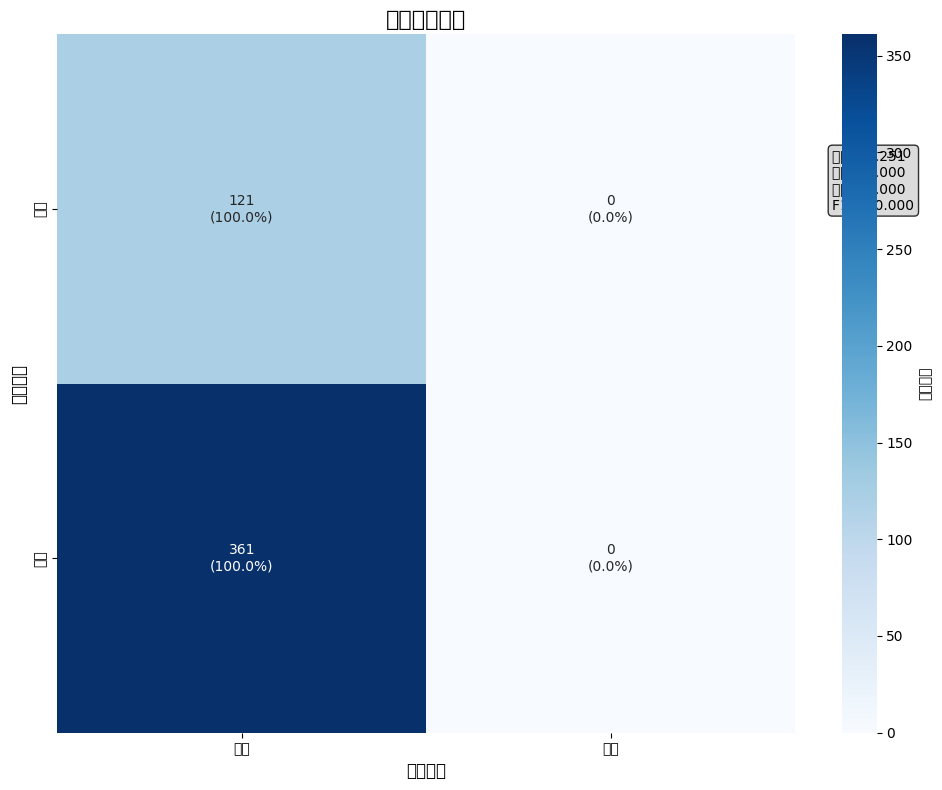

Ê∑∑Ê∑ÜÁü©ÈòµÂ∑≤‰øùÂ≠òÂà∞: ./results/evaluation/confusion_matrix.png


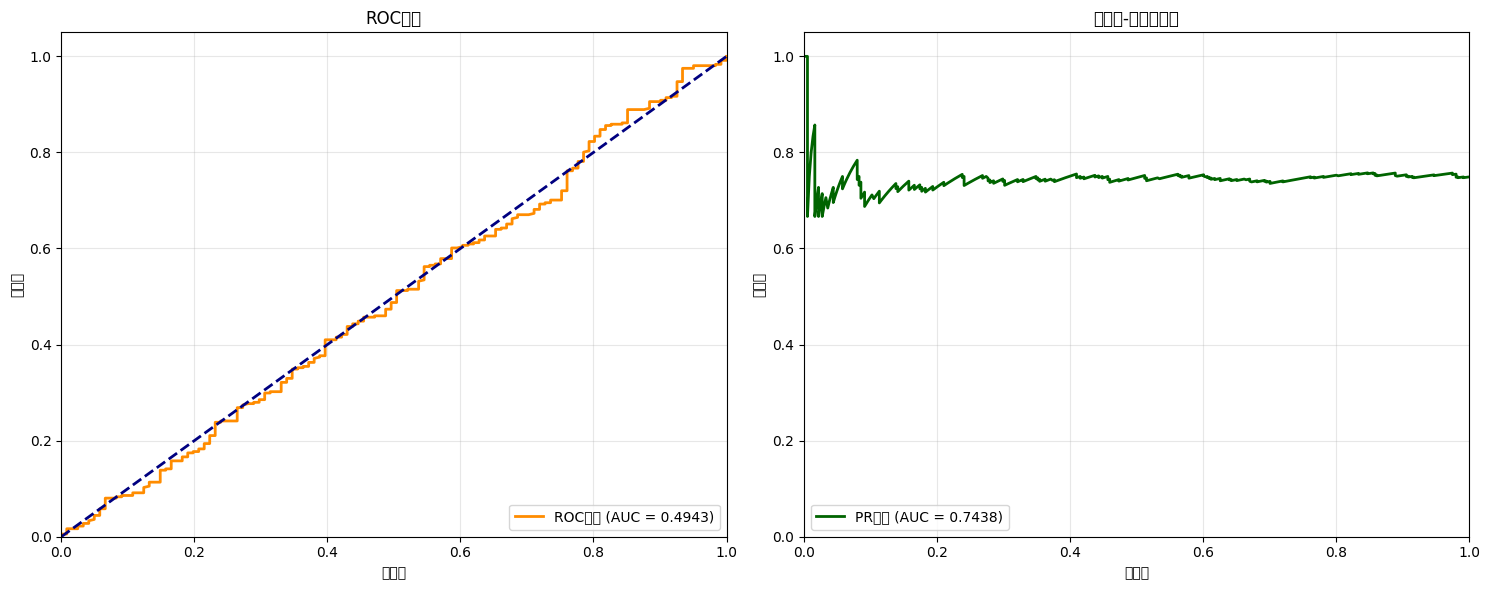

ROC/PRÊõ≤Á∫øÂ∑≤‰øùÂ≠òÂà∞: ./results/evaluation/roc_pr_curves.png


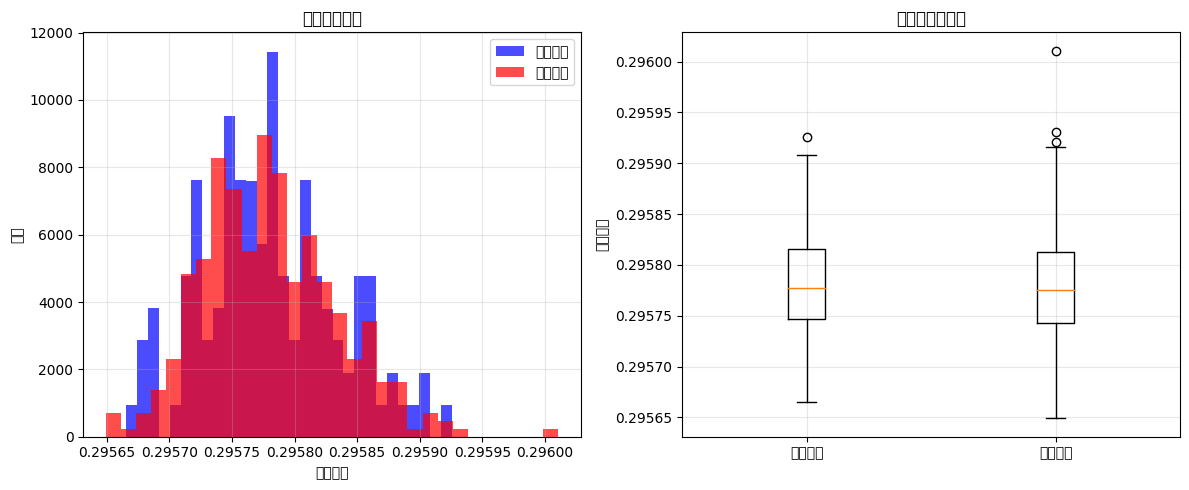

‚úÖ ËØÑ‰º∞ÂõæË°®ÁîüÊàêÂÆåÊàê

üìä Á±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûêÊä•Âëä

üìà Êï∞ÊçÆÂàÜÂ∏É:
  ÁúüÂÆûËßÜÈ¢ëÊ†∑Êú¨: 121
  ‰º™ÈÄ†ËßÜÈ¢ëÊ†∑Êú¨: 361
  ‰∏çÂπ≥Ë°°ÊØî‰æã: 2.98:1 (‰º™ÈÄ†:ÁúüÂÆû)

üéØ Á±ªÂà´ÁâπÂÆöÂáÜÁ°ÆÁéá:
  ÁúüÂÆûËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: 100.00%
  ‰º™ÈÄ†ËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: 0.00%

üìã Ê∑∑Ê∑ÜÁü©ÈòµÂàÜÊûê:
  ÁúüË¥ü‰æã (TN): 121 - Ê≠£Á°ÆËØÜÂà´ÁöÑÁúüÂÆûËßÜÈ¢ë
  ÂÅáÊ≠£‰æã (FP): 0 - ËØØÂà§‰∏∫‰º™ÈÄ†ÁöÑÁúüÂÆûËßÜÈ¢ë
  ÂÅáË¥ü‰æã (FN): 361 - ËØØÂà§‰∏∫ÁúüÂÆûÁöÑ‰º™ÈÄ†ËßÜÈ¢ë
  ÁúüÊ≠£‰æã (TP): 0 - Ê≠£Á°ÆËØÜÂà´ÁöÑ‰º™ÈÄ†ËßÜÈ¢ë

‚öñÔ∏è Ê®°ÂûãÂÅèÂêëÊÄßÂàÜÊûê:
  È¢ÑÊµã‰∏∫ÁúüÂÆûÁöÑÊ†∑Êú¨: 482 (100.0%)
  È¢ÑÊµã‰∏∫‰º™ÈÄ†ÁöÑÊ†∑Êú¨: 0 (0.0%)

üîç ÈóÆÈ¢òËØäÊñ≠:
  ‚úÖ ÁúüÂÆûËßÜÈ¢ëËØÜÂà´ËÉΩÂäõÊ≠£Â∏∏
  ‚ùå AUC-ROCËøá‰Ωé: Ê®°ÂûãÂà§Âà´ËÉΩÂäõÊé•ËøëÈöèÊú∫ÁåúÊµã

üí° ÊîπËøõÂª∫ËÆÆ:
  7. ÈáçÊñ∞ËÆæËÆ°Ê®°ÂûãÊû∂ÊûÑ
  8. Â¢ûÂä†Ê®°ÂûãÂ§çÊùÇÂ∫¶Êàñ‰ΩøÁî®È¢ÑËÆ≠ÁªÉÊ®°Âûã
  9. Ê£ÄÊü•ÁâπÂæÅÊèêÂèñÊòØÂê¶ÊúâÊïà
üéâ Ê®°ÂûãËØÑ‰º∞ÂÆåÊàêÔºÅ
üìÅ ÊâÄÊúâÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞ ./results/evaluation/ ÁõÆÂΩï

üí° Â¶ÇÊûúÂèëÁé∞‰∏•ÈáçÁöÑÁ±ªÂà´ÂÅ

In [14]:
# Cell 13: Ê®°ÂûãËØÑ‰º∞ÂíåÁªìÊûúÂàÜÊûê

import torch
import os

print("üìä ÂºÄÂßãÊ®°ÂûãËØÑ‰º∞...")
print("=" * 60)

# Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
print("üîÑ Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...")
try:
    # ‰ΩøÁî®weights_only=FalseÊù•ÂÖºÂÆπÊóßÁâàÊú¨ÁöÑÊ®°ÂûãÊñá‰ª∂
    checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÁ¨¨ {best_epoch+1} ËΩÆÁöÑÊúÄ‰Ω≥Ê®°Âûã")
    print(f"ÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: {best_val_acc:.2f}%")
    print(f"ÊúÄ‰Ω≥È™åËØÅAUC: {best_val_auc:.4f}")
except Exception as e:
    print(f"‚ùå Âä†ËΩΩÊ®°ÂûãÂ§±Ë¥•: {e}")
    print("‰ΩøÁî®ÂΩìÂâçÊ®°ÂûãËøõË°åËØÑ‰º∞")

# Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞Ê®°Âûã
print("\nüîç Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞Ê®°Âûã...")
eval_results = evaluate_model_optimized(model, test_loader, criterion, device)

# ËÆ°ÁÆóÂÖ®Èù¢ÁöÑËØÑ‰º∞ÊåáÊ†á
print("\nüìà ËÆ°ÁÆóËØÑ‰º∞ÊåáÊ†á...")
metrics = calculate_comprehensive_metrics(
    eval_results['predictions'], 
    eval_results['targets'], 
    eval_results['scores']
)

# ÊâìÂç∞ËØ¶ÁªÜÁªìÊûú
print("\nüìä ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:")
print("=" * 50)
print(f"ÊµãËØïÊçüÂ§±: {eval_results['loss']:.4f}")
print(f"ÂáÜÁ°ÆÁéá: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"Âπ≥Ë°°ÂáÜÁ°ÆÁéá: {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
print(f"Á≤æÁ°ÆÁéá: {metrics['precision']:.4f}")
print(f"Âè¨ÂõûÁéá: {metrics['recall']:.4f}")
print(f"ÁâπÂºÇÊÄß: {metrics['specificity']:.4f}")
print(f"F1ÂàÜÊï∞: {metrics['f1']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"AUC-PR: {metrics['auc_pr']:.4f}")
print(f"Ë¥üÈ¢ÑÊµãÂÄº: {metrics['npv']:.4f}")

# Ê∑∑Ê∑ÜÁü©ÈòµËØ¶ÁªÜ‰ø°ÊÅØ
print("\nüîç Ê∑∑Ê∑ÜÁü©ÈòµÂàÜÊûê:")
print(f"ÁúüË¥ü‰æã (TN): {metrics['tn']}")
print(f"ÂÅáÊ≠£‰æã (FP): {metrics['fp']}")
print(f"ÂÅáË¥ü‰æã (FN): {metrics['fn']}")
print(f"ÁúüÊ≠£‰æã (TP): {metrics['tp']}")

# ÊÄßËÉΩÂàÜÊûê
print("\n‚ö° ÊÄßËÉΩÂàÜÊûê:")
print(f"Âπ≥ÂùáÊé®ÁêÜÊó∂Èó¥: {eval_results['avg_inference_time']*1000:.2f} ms/batch")
print(f"ÊÄªÊé®ÁêÜÊó∂Èó¥: {eval_results['total_inference_time']:.2f} Áßí")
print(f"ÊØè‰∏™Ê†∑Êú¨Êé®ÁêÜÊó∂Èó¥: {eval_results['avg_inference_time']*1000/batch_size:.2f} ms")

# ËÆ°ÁÆóÈ¢ùÂ§ñÊåáÊ†á
total_samples = len(eval_results['targets'])
real_samples = np.sum(eval_results['targets'] == 0)
fake_samples = np.sum(eval_results['targets'] == 1)
real_accuracy = np.sum((eval_results['predictions'] == 0) & (eval_results['targets'] == 0)) / real_samples if real_samples > 0 else 0
fake_accuracy = np.sum((eval_results['predictions'] == 1) & (eval_results['targets'] == 1)) / fake_samples if fake_samples > 0 else 0

print("\nüìã Á±ªÂà´ÁâπÂÆöÂàÜÊûê:")
print(f"ÊÄªÊ†∑Êú¨Êï∞: {total_samples}")
print(f"ÁúüÂÆûËßÜÈ¢ëÊ†∑Êú¨: {real_samples} ({real_samples/total_samples*100:.1f}%)")
print(f"‰º™ÈÄ†ËßÜÈ¢ëÊ†∑Êú¨: {fake_samples} ({fake_samples/total_samples*100:.1f}%)")
print(f"ÁúüÂÆûËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"‰º™ÈÄ†ËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")

# ÁîüÊàêÂèØËßÜÂåñÂõæË°®
print("\nüìä ÁîüÊàêËØÑ‰º∞ÂõæË°®...")

# Á°Æ‰øùÁªìÊûúÁõÆÂΩïÂ≠òÂú®
os.makedirs('./results/evaluation', exist_ok=True)

# ÁªòÂà∂Â¢ûÂº∫Ê∑∑Ê∑ÜÁü©Èòµ
plot_enhanced_confusion_matrix(
    metrics['confusion_matrix'], 
    './results/evaluation/confusion_matrix.png'
)

# ÁªòÂà∂ROCÂíåPRÊõ≤Á∫ø
plot_roc_pr_curves(
    eval_results['targets'], 
    eval_results['scores'], 
    './results/evaluation/roc_pr_curves.png'
)

# È¢ÑÊµãÂàÜÊï∞ÂàÜÂ∏ÉÂõæ
plt.figure(figsize=(12, 5))

# ÁúüÂÆûËßÜÈ¢ëÁöÑÈ¢ÑÊµãÂàÜÊï∞ÂàÜÂ∏É
plt.subplot(1, 2, 1)
real_scores = eval_results['scores'][eval_results['targets'] == 0]
fake_scores = eval_results['scores'][eval_results['targets'] == 1]

plt.hist(real_scores, bins=30, alpha=0.7, label='ÁúüÂÆûËßÜÈ¢ë', color='blue', density=True)
plt.hist(fake_scores, bins=30, alpha=0.7, label='‰º™ÈÄ†ËßÜÈ¢ë', color='red', density=True)
plt.xlabel('È¢ÑÊµãÂàÜÊï∞')
plt.ylabel('ÂØÜÂ∫¶')
plt.title('È¢ÑÊµãÂàÜÊï∞ÂàÜÂ∏É')
plt.legend()
plt.grid(True, alpha=0.3)

# È¢ÑÊµãÂàÜÊï∞ÁÆ±Á∫øÂõæ
plt.subplot(1, 2, 2)
scores_data = [real_scores, fake_scores]
labels = ['ÁúüÂÆûËßÜÈ¢ë', '‰º™ÈÄ†ËßÜÈ¢ë']
plt.boxplot(scores_data, labels=labels)
plt.ylabel('È¢ÑÊµãÂàÜÊï∞')
plt.title('È¢ÑÊµãÂàÜÊï∞ÁÆ±Á∫øÂõæ')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/evaluation/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("‚úÖ ËØÑ‰º∞ÂõæË°®ÁîüÊàêÂÆåÊàê")

# ÁîüÊàêËØ¶ÁªÜÁöÑÁ±ªÂà´‰∏çÂπ≥Ë°°ÂàÜÊûêÊä•Âëä
generate_class_imbalance_report(metrics)

print("=" * 60)
print("üéâ Ê®°ÂûãËØÑ‰º∞ÂÆåÊàêÔºÅ")
print("üìÅ ÊâÄÊúâÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞ ./results/evaluation/ ÁõÆÂΩï")
print("\nüí° Â¶ÇÊûúÂèëÁé∞‰∏•ÈáçÁöÑÁ±ªÂà´ÂÅèÂêëÈóÆÈ¢òÔºåËØ∑ÂèÇËÄÉ‰∏äËø∞ÊîπËøõÂª∫ËÆÆËøõË°å‰ºòÂåñ")

# Cell 14: ÁªìÊûú‰øùÂ≠òÂíåÊÄªÁªì


In [15]:
# Cell 14: ÁªìÊûú‰øùÂ≠òÂíåÊÄªÁªì

import os
import torch
import pandas as pd
from datetime import datetime

print("üíæ ‰øùÂ≠òÂÆûÈ™åÁªìÊûú...")
print("=" * 60)

# Á°Æ‰øùÁªìÊûúÁõÆÂΩïÂ≠òÂú®
os.makedirs('./results', exist_ok=True)

# ÂáÜÂ§á‰øùÂ≠òÁöÑÁªìÊûúÊï∞ÊçÆ
results_summary = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'OptimizedDeepfakeDetector',
        'backbone': 'resnet50',
        'total_epochs': len(train_history['train_loss']),
        'early_stopping': True
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'batch_size': batch_size
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'loss_function': 'FocalLoss',
        'scheduler': 'OneCycleLR',
        'early_stopping_patience': 7
    },
    'final_metrics': {
        'test_loss': float(eval_results['loss']),
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1']),
        'auc_roc': float(metrics['auc_roc'])
    },
    'confusion_matrix': {
        'tn': int(metrics['tn']),
        'fp': int(metrics['fp']),
        'fn': int(metrics['fn']),
        'tp': int(metrics['tp'])
    },
    'training_history': {
        'train_loss': [float(x) for x in train_history['train_loss']],
        'train_acc': [float(x) for x in train_history['train_acc']],
        'train_auc': [float(x) for x in train_history['train_auc']],
        'val_loss': [float(x) for x in train_history['val_loss']],
        'val_acc': [float(x) for x in train_history['val_acc']],
        'val_auc': [float(x) for x in train_history['val_auc']]
    },
    'class_specific_metrics': {
        'real_video_accuracy': float(real_accuracy),
        'fake_video_accuracy': float(fake_accuracy),
        'real_samples_count': int(real_samples),
        'fake_samples_count': int(fake_samples)
    }
}

# ‰øùÂ≠òÁªìÊûúÂà∞JSONÊñá‰ª∂
results_file = './results/experiment_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"‚úÖ ÂÆûÈ™åÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {results_file}")

# ‰øùÂ≠òËÆ≠ÁªÉÂéÜÂè≤Âà∞CSV
history_df = pd.DataFrame(train_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("‚úÖ ËÆ≠ÁªÉÂéÜÂè≤Â∑≤‰øùÂ≠òÂà∞: ./results/training_history.csv")

# ‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú
predictions_df = pd.DataFrame({
    'true_label': eval_results['targets'],
    'predicted_label': eval_results['predictions'],
    'prediction_score': eval_results['scores']
})
predictions_df.to_csv('./results/test_predictions.csv', index=False)
print("‚úÖ ÊµãËØïÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: ./results/test_predictions.csv")

# ÁîüÊàêÂÆûÈ™åÊä•Âëä
print("\nüìã ÁîüÊàêÂÆûÈ™åÊä•Âëä...")
report = f"""
Ê∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµãÊ®°ÂûãÂÆûÈ™åÊä•Âëä
{'='*50}

ÂÆûÈ™åÊó∂Èó¥: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Ê®°ÂûãÊû∂ÊûÑ: OptimizedDeepfakeDetector (ResNet50 + LSTM + Attention)

Êï∞ÊçÆÈõÜ‰ø°ÊÅØ:
- ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_dataset):,}
- È™åËØÅÊ†∑Êú¨: {len(val_dataset):,}
- ÊµãËØïÊ†∑Êú¨: {len(test_dataset):,}
- ÊâπÊ¨°Â§ßÂ∞è: {batch_size}

ËÆ≠ÁªÉÈÖçÁΩÆ:
- ‰ºòÂåñÂô®: AdamW (lr=1e-4, weight_decay=1e-4)
- ÊçüÂ§±ÂáΩÊï∞: Focal Loss
- Â≠¶‰π†ÁéáË∞ÉÂ∫¶: OneCycleLR
- Êó©ÂÅúÊú∫Âà∂: patience=7

ÊúÄÁªàÊÄßËÉΩÊåáÊ†á:
- ÂáÜÁ°ÆÁéá: {metrics['accuracy']*100:.2f}%
- Á≤æÁ°ÆÁéá: {metrics['precision']:.4f}
- Âè¨ÂõûÁéá: {metrics['recall']:.4f}
- F1ÂàÜÊï∞: {metrics['f1']:.4f}
- AUC-ROC: {metrics['auc_roc']:.4f}

Ê∑∑Ê∑ÜÁü©Èòµ:
- ÁúüË¥ü‰æã (TN): {metrics['tn']}
- ÂÅáÊ≠£‰æã (FP): {metrics['fp']}
- ÂÅáË¥ü‰æã (FN): {metrics['fn']}
- ÁúüÊ≠£‰æã (TP): {metrics['tp']}

Á±ªÂà´ÁâπÂÆöÊÄßËÉΩ:
- ÁúüÂÆûËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {real_accuracy*100:.2f}%
- ‰º™ÈÄ†ËßÜÈ¢ëÊ£ÄÊµãÂáÜÁ°ÆÁéá: {fake_accuracy*100:.2f}%

ËÆ≠ÁªÉÊÄªÁªì:
- ËÆ≠ÁªÉËΩÆÊï∞: {len(train_history['train_loss'])}
- ÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: {max(train_history['val_acc']):.2f}%
- ÊúÄ‰Ω≥È™åËØÅAUC: {max(train_history['val_auc']):.4f}

Êñá‰ª∂ËæìÂá∫:
- Ê®°ÂûãÊùÉÈáç: ./models/best_model.pth
- ÂÆûÈ™åÁªìÊûú: ./results/experiment_results.json
- ËÆ≠ÁªÉÂéÜÂè≤: ./results/training_history.csv
- È¢ÑÊµãÁªìÊûú: ./results/test_predictions.csv

{'='*50}
ÂÆûÈ™åÂÆåÊàêÊó∂Èó¥: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# ‰øùÂ≠òÊä•Âëä
with open('./results/experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("‚úÖ ÂÆûÈ™åÊä•ÂëäÂ∑≤‰øùÂ≠òÂà∞: ./results/experiment_report.txt")

# ÊâìÂç∞ÊúÄÁªàÊÄªÁªì
print("\n" + "="*60)
print("üéâ Ê∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµãÊ®°ÂûãËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàêÔºÅ")
print("="*60)
print(f"üìä ÊúÄÁªàÊµãËØïÂáÜÁ°ÆÁéá: {metrics['accuracy']*100:.2f}%")
print(f"üìä AUC-ROCÂàÜÊï∞: {metrics['auc_roc']:.4f}")
print(f"üìä F1ÂàÜÊï∞: {metrics['f1']:.4f}")
print("\nüìÅ ÊâÄÊúâÁªìÊûúÊñá‰ª∂Â∑≤‰øùÂ≠òÂà∞ ./results/ ÁõÆÂΩï")
print("üìÅ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÂà∞ ./models/best_model.pth")
print("\n‚ú® ÂÆûÈ™åÊàêÂäüÂÆåÊàêÔºÅ")
print("="*60)

# ÊòæÁ§∫Êñá‰ª∂ÁªìÊûÑ
print("\nüìÇ ÁîüÊàêÁöÑÊñá‰ª∂ÁªìÊûÑ:")
print("""
./models/
  ‚îî‚îÄ‚îÄ best_model.pth
./results/
  ‚îú‚îÄ‚îÄ experiment_results.json
  ‚îú‚îÄ‚îÄ experiment_report.txt
  ‚îú‚îÄ‚îÄ training_history.csv
  ‚îî‚îÄ‚îÄ test_predictions.csv
""")

print("\nüöÄ ÂèØ‰ª•‰ΩøÁî®‰ª•‰∏ã‰ª£Á†ÅÂä†ËΩΩËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãËøõË°åÊé®ÁêÜ:")
print("""
# Âä†ËΩΩÊ®°Âûã
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
""")

print("\n‚úÖ Kaggle T4 GPU‰ºòÂåñÁâàÊú¨ - ËÆ≠ÁªÉÂÆåÊàêÔºÅ")

üíæ ‰øùÂ≠òÂÆûÈ™åÁªìÊûú...
‚úÖ ÂÆûÈ™åÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: ./results/experiment_results.json
‚úÖ ËÆ≠ÁªÉÂéÜÂè≤Â∑≤‰øùÂ≠òÂà∞: ./results/training_history.csv
‚úÖ ÊµãËØïÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: ./results/test_predictions.csv

üìã ÁîüÊàêÂÆûÈ™åÊä•Âëä...
‚úÖ ÂÆûÈ™åÊä•ÂëäÂ∑≤‰øùÂ≠òÂà∞: ./results/experiment_report.txt

üéâ Ê∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµãÊ®°ÂûãËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàêÔºÅ
üìä ÊúÄÁªàÊµãËØïÂáÜÁ°ÆÁéá: 25.10%
üìä AUC-ROCÂàÜÊï∞: 0.4943
üìä F1ÂàÜÊï∞: 0.0000

üìÅ ÊâÄÊúâÁªìÊûúÊñá‰ª∂Â∑≤‰øùÂ≠òÂà∞ ./results/ ÁõÆÂΩï
üìÅ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÂà∞ ./models/best_model.pth

‚ú® ÂÆûÈ™åÊàêÂäüÂÆåÊàêÔºÅ

üìÇ ÁîüÊàêÁöÑÊñá‰ª∂ÁªìÊûÑ:

./models/
  ‚îî‚îÄ‚îÄ best_model.pth
./results/
  ‚îú‚îÄ‚îÄ experiment_results.json
  ‚îú‚îÄ‚îÄ experiment_report.txt
  ‚îú‚îÄ‚îÄ training_history.csv
  ‚îî‚îÄ‚îÄ test_predictions.csv


üöÄ ÂèØ‰ª•‰ΩøÁî®‰ª•‰∏ã‰ª£Á†ÅÂä†ËΩΩËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãËøõË°åÊé®ÁêÜ:

# Âä†ËΩΩÊ®°Âûã
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.l